In [ ]:
# %pip install -U pip datasets ipywidgets
# For mac OS
# %pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1 keras-nlp
# For Intel mac
# %pip install -U tensorflow==2.16.2 keras==3.4.1 keras-nlp
# For AWS SageMaker
# %pip install -U tensorflow==2.16.2 tensorflow-datasets keras==3.4.1 keras-nlp datasets

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Utility function to determine where this note is running
import platform

def is_running_on_apple_silicon():
    return platform.system() == "Darwin" and platform.processor() == "arm"

def is_running_on_intel_mac():
    return platform.system() == "Darwin" and platform.processor() == "i386"

DEVELOPMENT = is_running_on_apple_silicon()
DEVELOPMENT = False
DEBUGGER_V2 = False

In [3]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.16.2 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

if is_running_on_apple_silicon() or is_running_on_intel_mac():
    FLOAT_TYPE = tf.float32
else:
    """
    # Mixed-precision training
    Deep Learning with Python, Second Edition
    François Chollet

    However, this makes the processing 2.x slower on M2 Apple Silicon.

    Machine | 1 step
    --- | ---
    Intel Mac fp16 | 12s
    Intel Mac fp32 | 7s
    Apple Silicon Mac fp16 | 1.8s
    Apple Silicon Mac fp32 | 640ms
    ml.p3.2xlarge | 166ms
    """
    keras.mixed_precision.set_global_policy("mixed_float16")
    FLOAT_TYPE = tf.float16

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving
import datetime

Tensorflow 2.16.2 is expected. The running version is 2.16.2
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [4]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

In [5]:
def plot_model(model, custom_objects={}):
    if isinstance(model, str):
        model = keras.models.load_model(
            model,
            custom_objects=custom_objects
        )
    keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True
    )

In [6]:
def get_log_dir(now):
    log_dir = "logs/fit/" + now.strftime("%Y%m%d-%H%M%S")
    return log_dir

def get_tensorboard_callback(now):
    # @see https://www.tensorflow.org/tensorboard/get_started
    log_dir = get_log_dir(now=now)
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    return tensorboard_callback

In [7]:
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    s = tf.strings.lower(input_string)
    s = tf.strings.regex_replace(s, r'\n', ' ')
    s = tf.strings.regex_replace(s, r'\\n', ' ')
    s = tf.strings.regex_replace(s, r'<br />', ' ')
    s = tf.strings.regex_replace(s, r"'", ' ')
    s = tf.strings.regex_replace(s, r'&amp;', '')
    s = tf.strings.regex_replace(s, r'[_"\-;%()|+&=*%.,!?:#$@/]', ' ')
    s = tf.strings.regex_replace(s, r'<\/?[^>]*>', '') # html tag
    #s = tf.strings.regex_replace(s, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    s = tf.strings.regex_replace(s, r'https?:\/\/.*[\r\n]*', " ") # URL
    s = tf.strings.regex_replace(s, "[%s]" % re.escape(strip_chars), "")
    return s

In [8]:
def get_exponential_decay_learning_rate(initial_learning_rate, decay_steps, decay_rate):
    if decay_rate < 1.0:
        learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
        return learning_rate
    else:
        return initial_learning_rate

def get_default_optimizer(initial_learning_rate, decay_steps, decay_rate):
    learning_rate = get_exponential_decay_learning_rate(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
    )
    if f"{keras.__version__}".startswith("2.") and (is_running_on_apple_silicon() or is_running_on_intel_mac()):
        optimizer = keras.optimizers.legacy.Adam(
            learning_rate=learning_rate,
        )
    else:
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
        )
    return optimizer


In [9]:
# @see https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr_callbacks = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=0.04,
    cooldown=8,
    min_lr=2e-5, # 5e-4: 0.0005, 2e-5: 0.00002
)

In [10]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [11]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# @saving.register_keras_serializable()
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1) # last index
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=FLOAT_TYPE)
#     mask = tf.cast(y_true != 0, dtype=FLOAT_TYPE)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=FLOAT_TYPE)
    mask = tf.cast(mask, dtype=FLOAT_TYPE)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [12]:
def rouge_n(y_true, y_pred, order=2):
    rouge_n = keras_nlp.metrics.RougeN(order=order)
    return rouge_n(y_true, y_pred)

In [13]:
@saving.register_keras_serializable()
class BaseSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, **kwargs):
        super().__init__()
        self.lr = kwargs['lr']
        self.decay_start =  kwargs.get('decay_start', 0.0)
        self.decay_ratio = kwargs.get('decay_ratio', 1.0)
        self.beta_2 = kwargs.get('beta_2', 0.999)

    def get_config(self):
        config = {
            "lr": float(self.lr), 
            "decay_start": float(self.decay_start),
            "decay_ratio": float(self.decay_ratio),
            "beta_2": float(self.beta_2)
        }
        return config

    def __call__(self, step):
        return tf.where(
            step >= self.decay_start,
            self.decay_ratio*self.lr,
            self.lr
        )

@saving.register_keras_serializable()
class RectifiedAdamSchedule(BaseSchedule):
    def __call__(self, step):
        lr = super().__call__(step)
        f_step = tf.cast(step, tf.float32)
        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        beta2_power = tf.pow(self.beta_2, f_step)
        sma_t = sma_inf - 2.0 * f_step * beta2_power / (1.0 - beta2_power)
        r_t =  tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) / (sma_inf - 2.0) * sma_inf / sma_t)
        return tf.where(
            sma_t > 4.0,
            r_t*lr,
            0.0
        )

@saving.register_keras_serializable()
class ExponentialWarmupSchedule(BaseSchedule):
    def __call__(self, step):
        lr = super().__call__(step)
        f_step = tf.cast(step, tf.float32)
        return (1.0 - tf.math.exp( -(1.0-self.beta_2)*f_step ))*lr

@saving.register_keras_serializable()
class LinearWarmupSchedule(BaseSchedule):
    def __call__(self, step):
        lr = super().__call__(step)
        f_step = tf.cast(step, tf.float32)
        return tf.math.minimum( 1.0, (1-self.beta_2)/2*f_step )*lr


## Dataset

In [14]:
import datasets

def prepare_datasets():
    # How to convert huggingface dataset to tensorflow dataset
    # @see https://huggingface.co/docs/datasets/v1.3.0/torch_tensorflow.html#setting-the-format
    def convert_hf2tf(
            dataset: datasets.DatasetDict,
            split: list[str],
            columns=['article', 'highlights', 'id',]):
        dataset.set_format(
            type='tensorflow',
            columns=columns
        )
        l = []
        for s in split:
            d = dataset[s]
            features = {x: d[x] for x in columns}
            # .batch(32) is not used to show a simple sampled data below with take(1)
            tf_dataset = tf.data.Dataset.from_tensor_slices(features)
            l.append(tf_dataset)
        return tuple(l)
    ds = datasets.load_dataset(
        'Samsung/samsum',
        trust_remote_code=True
    )
    train_ds, validation_ds, test_ds = convert_hf2tf(
        dataset=ds,
        split=['train', 'validation', 'test'],
        columns=['id', 'summary', 'dialogue'],
    )
    # for development with 1/10 entries
    if DEVELOPMENT:
        train_size = len(train_ds) // 100 * 90
        validation_size = len(validation_ds) // 100 * 90
        test_size = len(test_ds) // 100 * 90
        train_ds = train_ds.skip(train_size)
        validation_ds = validation_ds.skip(validation_size)
        test_ds = test_ds.skip(test_size)
    return train_ds, validation_ds, test_ds

In [15]:
def prepare_tokenizer(
        vectorization_layer,
        encoder_sequence_length,
        decoder_sequence_length,
        max_tokens=15000):
    """
    Display the plot that indicates the loss and accuracy.
    :param vectorization_layer: obtain vocabulary.
    :param max_tokens: In other words, this is the vocabulary size.
    :param encoder_sequence_length: The sequence length for input.
    :param input_output_sequence_length: The sequence length for target.
    """
    vocabulary = vectorization_layer.get_vocabulary()

    input_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=encoder_sequence_length,
    )
    target_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=decoder_sequence_length,
    )
    input_vectorization_layer.set_vocabulary(vocabulary)
    target_vectorization_layer.set_vocabulary(vocabulary)
    return input_vectorization_layer, target_vectorization_layer

def build_datasets(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        batch_size,
        encoder_sequence_length,
        decoder_sequence_length):
    """
    vectorization_layer(['This is a pen', 'I am a software engineer'])
    #vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    # 2
    rows = vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    vectorization_layer(['This is a pen', 'I am a software engineer']).to_tensor(shape=(rows, 10))
    # .to_tensor()

    RaggedTensor.to_tensor can make 0-filled Tensor
    """
    def format_dataset(x):
        # decoder_sequence_length: either the following 2.
        # - decoder input: [start] + sentence
        # - decoder output: sentence + [end]
        # That is, decoder_sequence_length = sentence length + 1
        summarized_text_length = decoder_sequence_length - 1

        d = vectorization_layer(x['dialogue'])
        r = d.row_lengths().shape[0]
        dialogue = d.to_tensor(shape=(r, encoder_sequence_length))

        start_oov = vectorization_layer(['[start]']).to_tensor(shape=(1, 1))
        end_oov = vectorization_layer(['[end]']).to_tensor(shape=(1, 1))
        summary = vectorization_layer(x['summary'])
        """
        print(h.row_lengths().shape[0]) None
        print(tf.shape(h)[0]) Tensor("RaggedShape/Cast_3:0", shape=(), dtype=int32)
        At the last step, the number of rows is not equal to the batch size.
        """
        rows = tf.shape(summary)[0]
        summary = summary[:rows, :summarized_text_length]
        start_oov = tf.repeat(start_oov, repeats=rows , axis=0)
        end_oov = tf.repeat(end_oov, repeats=rows , axis=0)
        summary = tf.concat([start_oov, summary, end_oov], axis=1)

        sequences = summary.to_tensor(shape=(
            rows,
            summarized_text_length + 1 + 1 # start + sentence + end
        ))

        summary_decoder_input = sequences[:, :-1] # start + sentence
        summary_decoder_output = sequences[:, 1:] # sentence + end
        return (
            (
                dialogue, # encoder input
                summary_decoder_input, # decoder input
            ),
            summary_decoder_output, # decoder output
            tf.cast((summary_decoder_output != 0), dtype=FLOAT_TYPE)
        )
    train_ds = train_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    validation_ds = validation_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    test_ds = test_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    return train_ds, validation_ds, test_ds


## Model

In [16]:
@saving.register_keras_serializable()
class TransformerEncoderDecoderModel(keras.Model):
    def __init__(
        self,
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual,
        **kwargs):
        super(TransformerEncoderDecoderModel, self).__init__(**kwargs)
        self.mask_zero = mask_zero
        self.layer_norm_epsilon = layer_norm_epsilon
        self.use_residual = use_residual
        self.encoders = []
        self.decoders = []
        if isinstance(layer_norm_epsilon, list):
            encoder_layer_norm_epsilons = layer_norm_epsilon
            decoder_layer_norm_epsilons = layer_norm_epsilon
        else:
            encoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_encoders)]
            decoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_decoders)]

        for i in range(num_encoders):
            self.encoders.append(
                keras_nlp.layers.TransformerEncoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                    normalize_first=normalize_first,
                    layer_norm_epsilon=encoder_layer_norm_epsilons[i],
                    name=f"encoder_{i}",
                )
            )
        for _ in range(num_decoders):
            self.decoders.append(
                keras_nlp.layers.TransformerDecoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                    normalize_first=normalize_first,
                    layer_norm_epsilon=decoder_layer_norm_epsilons[i],
                    name=f"decoder_{i}",
                )
            )

        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer

        self.encoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=encoder_vocabulary_size,
            sequence_length=encoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=mask_zero,
            name="encoder_embed",
        )

        self.decoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=decoder_vocabulary_size,
            sequence_length=decoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=mask_zero,
            name="decoder_embed",
        )

        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            name="dense",
        )

    def build(self, input_shape):
        """
        @see https://github.com/keras-team/keras/issues/19535#issuecomment-2060299275
        fcollet has answered and explained how to implement for the following warning.

        ```
        UserWarning: `build()` was called on layer 'transformer_encoder_decoder_model_*',
        however the layer does not have a `build()` method implemented and it looks like it has unbuilt state.
        This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line.
        Make sure to implement a proper `build()` method
        ```

        The incorrect implementation of this method causes the following problem:
        - When the model is generated from .keras file, the loaded model does not work correctly.
        """
        self.encoder_embedding.build(input_shape[0])
        self.decoder_embedding.build(input_shape[1])
        encoder_output_shape = self.encoder_embedding.compute_output_shape(input_shape[0])
        decoder_output_shape = self.decoder_embedding.compute_output_shape(input_shape[1])

        for encoder in self.encoders:
            encoder.build(inputs_shape=encoder_output_shape)
            encoder_output_shape = encoder.compute_output_shape(
                inputs_shape=encoder_output_shape
            )
        for decoder in self.decoders:
            decoder.build(
                decoder_sequence_shape=decoder_output_shape,
                encoder_sequence_shape=encoder_output_shape,
            )
            decoder_output_shape = decoder.compute_output_shape(
                decoder_sequence_shape=decoder_output_shape,
            )

        self.dense.build(input_shape=decoder_output_shape)
        self.built = True

    def call(self, inputs, training=False):
        # training=True: when calculating val_loss and val_acc
        encoder_input, decoder_input = (
            inputs[0],
            inputs[1],
        )
        encoded = self.encoder_embedding(encoder_input)
        for encoder in self.encoders:
            if self.use_residual and len(self.encoders) > 1:
                residual = encoded
            encoded = encoder(
                inputs=encoded,
                training=training,
            )
            if self.use_residual and len(self.encoders) > 1:
                encoded = encoded + residual

        decoded = self.decoder_embedding(decoder_input)
        for decoder in self.decoders:
            if self.use_residual and len(self.decoders) > 1:
                residual = decoded
            decoded = decoder(
                decoder_sequence=decoded,
                encoder_sequence=encoded,
                use_causal_mask=True,
                training=training,
            )
            if self.use_residual and len(self.decoders) > 1:
                decoded = decoded + residual

        output = self.dense(decoded)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del output._keras_mask
        except AttributeError:
            pass
        return output

    def get_config(self):
        #config = super(TransformerEncoderDecoderModel, self).get_config()
        config = super(TransformerEncoderDecoderModel, self).get_config().copy()
        config.update({
            "encoder_tokenizer": self.encoder_tokenizer.get_config(),
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "num_encoders": len(self.encoders),
            "num_decoders": len(self.decoders),
            "num_heads": self.encoders[0].num_heads,
            "transformer_intermediate_dim": self.encoders[0].intermediate_dim,
            "normalize_first": self.encoders[0].normalize_first,
            "layer_norm_epsilon": self.layer_norm_epsilon,
            "encoder_vocabulary_size": self.encoder_embedding.vocabulary_size,
            "decoder_vocabulary_size": self.decoder_embedding.vocabulary_size,
            "embedding_dim": self.encoder_embedding.embedding_dim,
            "mask_zero": self.mask_zero,
            "encoder_sequence_length": self.encoder_embedding.sequence_length,
            "decoder_sequence_length": self.decoder_embedding.sequence_length,
            "use_residual": self.use_residual,
        })
        return config
    @classmethod
    def from_config(cls, config):
        encoder_tokenizer_config = config.pop("encoder_tokenizer")
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        encoder_tokenizer = keras.layers.TextVectorization.from_config(encoder_tokenizer_config)
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(
            encoder_tokenizer=encoder_tokenizer,
            decoder_tokenizer=decoder_tokenizer,
            **config
        )

## Train

In [17]:
def run_training(
        model,
        train_ds,
        validation_ds,
        optimizer,
        epochs,
        steps_per_epoch,
        now,
        callbacks=[]):
    metrics = [
        masked_acc,
        #keras.metrics.SparseCategoricalAccuracy(),
        #keras_nlp.metrics.Bleu(), #  This cannot be used here
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        weighted_metrics=[],
    )
    callbacks.append(get_tensorboard_callback(now=now))
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
    )
    return history


In [18]:
def build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        callbacks=[]):
    now = datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = TransformerEncoderDecoderModel(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=normalize_first,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        use_residual=use_residual,
    )
    # This should be called seemingly.
    model.build(
        input_shape=(
            (None, encoder_sequence_length),
            (None, decoder_sequence_length)
        )
    )

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Functional API

In [19]:
# Functional API cannot hold tokenizer inside.
# They must be saved externally.
def create_model_functionally(
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual):
    if isinstance(layer_norm_epsilon, list):
        encoder_layer_norm_epsilons = layer_norm_epsilon
        decoder_layer_norm_epsilons = layer_norm_epsilon
    else:
        encoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_encoders)]
        decoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_decoders)]

    encoder_inputs = keras.Input(
        shape=(encoder_sequence_length,),
        name="encoder_inputs",
        dtype="int64",
    )
    decoder_inputs = keras.Input(
        shape=(decoder_sequence_length,),
        name="decoder_inputs",
        dtype="int64",
    )

    # encoder_tokenized_outputs = encoder_tokenizer(encoder_inputs)
    # decoder_tokenized_outputs = decoder_tokenizer(decoder_inputs)

    encoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=encoder_vocabulary_size,
        sequence_length=encoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        name="encoder_embed",
    )(encoder_inputs)

    decoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=decoder_vocabulary_size,
        sequence_length=decoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        name="decoder_embed",
    )(decoder_inputs)

    for i in range(num_encoders):
        if use_residual and len(num_encoders) > 1:
            residual = encoder_outputs
        encoder_outputs = keras_nlp.layers.TransformerEncoder(
            num_heads=num_heads,
            intermediate_dim=transformer_intermediate_dim,
            normalize_first=normalize_first,
            layer_norm_epsilon=encoder_layer_norm_epsilons[i],
            name=f"encoder_{i}",
        )(inputs=encoder_outputs)
        if use_residual and len(num_encoders) > 1:
            encoder_outputs = encoder_outputs + residual
    for i in range(num_decoders):
        if use_residual and len(num_decoders) > 1:
            residual = decoder_outputs
        decoder_outputs = keras_nlp.layers.TransformerDecoder(
            num_heads=num_heads,
            intermediate_dim=transformer_intermediate_dim,
            normalize_first=normalize_first,
            layer_norm_epsilon=decoder_layer_norm_epsilons[i],
            name=f"decoder_{i}",
        )(
            decoder_sequence=decoder_outputs,
            encoder_sequence=encoder_outputs,
            use_causal_mask=True,
        )
        if use_residual and len(num_decoders) > 1:
            decoder_outputs = decoder_outputs + residual
    outputs = keras.layers.Dense(
        decoder_vocabulary_size,
        name="dense",
    )(decoder_outputs)

    model = keras.Model(
        inputs=[encoder_inputs, decoder_inputs],
        outputs=outputs,
        name="transformer_encoder_decoder_model"
    )
    return model

def build_model_functionally(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        callbacks=[]):
    now=datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = create_model_functionally(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=normalize_first,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        use_residual=use_residual,
    )
    model.summary()

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Decode and Predict

In [50]:
EXAMPLES = [
    """(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never seriously in doubt once he got the baton safely in hand from Ashmeade, while Gatlin and the United States third leg runner Rakieem Salaam had problems. Gatlin strayed out of his lane as he struggled to get full control of their baton and was never able to get on terms with Bolt. Earlier, Jamaica\'s women underlined their dominance in the sprint events by winning the 4x100m relay gold, anchored by Shelly-Ann Fraser-Pryce, who like Bolt was completing a triple. Their quartet recorded a championship record of 41.29 seconds, well clear of France, who crossed the line in second place in 42.73 seconds. Defending champions, the United States, were initially back in the bronze medal position after losing time on the second handover between Alexandria Anderson and English Gardner, but promoted to silver when France were subsequently disqualified for an illegal handover. The British quartet, who were initially fourth, were promoted to the bronze which eluded their men\'s team. Fraser-Pryce, like Bolt aged 26, became the first woman to achieve three golds in the 100-200 and the relay. In other final action on the last day of the championships, France\'s Teddy Tamgho became the third man to leap over 18m in the triple jump, exceeding the mark by four centimeters to take gold. Germany\'s Christina Obergfoll finally took gold at global level in the women\'s javelin after five previous silvers, while Kenya\'s Asbel Kiprop easily won a tactical men\'s 1500m final. Kiprop\'s compatriot Eunice Jepkoech Sum was a surprise winner of the women\'s 800m. Bolt\'s final dash for golden glory brought the eight-day championship to a rousing finale, but while the hosts topped the medal table from the United States there was criticism of the poor attendances in the Luzhniki Stadium. There was further concern when their pole vault gold medalist Yelena Isinbayeva made controversial remarks in support of Russia\'s new laws, which make "the propagandizing of non-traditional sexual relations among minors" a criminal offense. She later attempted to clarify her comments, but there were renewed calls by gay rights groups for a boycott of the 2014 Winter Games in Sochi, the next major sports event in Russia.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend .""",
    "There are two chickens in the garden.",
    "Two chickens fell into the swimming pool in the garden.",
]

def decode_sequence(
        input_sentence,
        model,
        max_sequence_length,
        lookup_table):
    encoder_tokenizer = model.encoder_tokenizer
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = (
            tokenized_input,
            decoder_inputs,
        )
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    return " ".join(detokenized_output)


def predict_main(
        filepath,
        examples,
        decoder_sequence_length):
    loaded_model = keras.models.load_model(
        filepath,
        # Just in case, TransformerEncoderDecoderModel is specified.
        # However, it does not seem necessary.
        custom_objects={
            "TransformerEncoderDecoderModel": TransformerEncoderDecoderModel,
        }
    )

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                loaded_model,
                decoder_sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_model(
        model,
        examples,
        decoder_sequence_length):
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                model,
                decoder_sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_dataset(
        model,
        iterable_dataset,
        decoder_sequence_length):
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    y_trues = []
    y_preds = []
    for entry in iterable_dataset:
        text = entry["dialogue"]
        result = decode_sequence(
            text,
            model,
            decoder_sequence_length,
            index_lookup_table,
        )
        y_true = entry["summary"]
        y_true = y_true.decode('utf-8').lower()
        y_pred = result.replace('[start]', '').replace('[end]', '').strip()
        # print(y_true, '\n\t' , y_pred)
        y_trues.append(y_true)
        y_preds.append(y_pred)
    # RougeN metric
    # @see https://keras.io/api/keras_nlp/metrics/rouge_n/
    rouge_n = keras_nlp.metrics.RougeN(order=2)
    rouge = rouge_n(y_true, y_pred)
    return y_trues, y_preds, rouge


***

# Build

batch size | CPU | GPU
--- | --- | ---
--- | 7m52s | > 25m
32 | 1m41s | 2m26s
64 | 1m37s | 2m5s
128 | 1m37s | 1m49s
256 | 1m31s | 1m40s

In [21]:
ADAPT_BATCH_SIZE = 256

train_ds, validation_ds, test_ds = prepare_datasets()
vectorization_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    # max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    ragged=True,
)
vectorization_layer.adapt(
    train_ds.batch(ADAPT_BATCH_SIZE).map(
        lambda row: '[start] ' + row['summary'] + ' ' + row['dialogue'] + ' [end]',
        num_parallel_calls=tf.data.AUTOTUNE,
    ),
    batch_size=ADAPT_BATCH_SIZE,
)
# Use the maximum size of the dataset. 31907
VOCABULARY_SIZE = len(vectorization_layer.get_vocabulary())

2024-07-30 13:18:05.189419: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-30 13:18:05.189443: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-07-30 13:18:05.189446: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-07-30 13:18:05.189723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-30 13:18:05.189739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-30 13:18:06.323402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Note (Experiment Date: 2024-07-30 13:23:00)

Compare that Rouge N score.

#### Result


#### Next



Epoch 1/50


2024-07-30 13:24:15.122724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - loss: 5.0198 - masked_acc: 0.0558 - val_loss: 3.6826 - val_masked_acc: 0.1414 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - loss: 3.5387 - masked_acc: 0.1570 - val_loss: 3.4354 - val_masked_acc: 0.1723 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - loss: 3.2393 - masked_acc: 0.1920 - val_loss: 3.3588 - val_masked_acc: 0.1821 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - loss: 3.0327 - masked_acc: 0.2209 - val_loss: 3.3028 - val_masked_acc: 0.1943 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 2.8408 - masked_acc: 0.2486 - val_loss: 3.3009 - val_masked_acc: 0.2026 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 2.6403 - masked_acc: 0.2830 - val_loss: 3.2973 - val_masked_acc: 0.2117 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - 

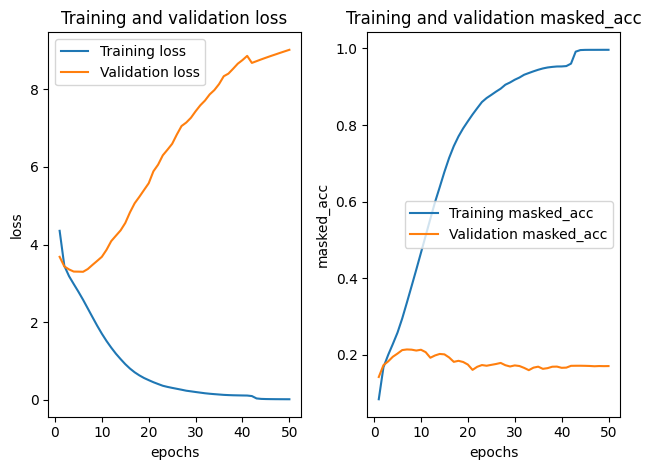

3.297281503677368 The best number of epocs for the validation loss is 6
0.21336261928081512 The best number of epocs for the validation accuracy is 7


In [22]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

y_true, y_pred, rouge = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge

### Note (Experiment Date: 2024-07-16 00:35:37)

Multiple layers 6, 4, and 2.

#### Result

It is preferable that the number of layers is more than or equal to 4.

#### Next

Compare that Rouge N score.

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 215s 481ms/step - loss: 4.3887 - masked_acc: 0.0816 - val_loss: 3.4090 - val_masked_acc: 0.1724 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 77s 328ms/step - loss: 3.2072 - masked_acc: 0.1938 - val_loss: 3.1998 - val_masked_acc: 0.2185 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 322ms/step - loss: 2.7499 - masked_acc: 0.2614 - val_loss: 3.1550 - val_masked_acc: 0.2377 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 321ms/step - loss: 2.3535 - masked_acc: 0.3178 - val_loss: 3.2483 - val_masked_acc: 0.2223 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 76s 327ms/step - loss: 2.0171 - masked_acc: 0.3734 - val_loss: 3.4084 - val_masked_acc: 0.2226 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 77s 330ms/step - loss: 1.7194 - masked_acc: 0.4320 - val_loss: 3.6067 - val_masked_acc: 0.2184 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 3

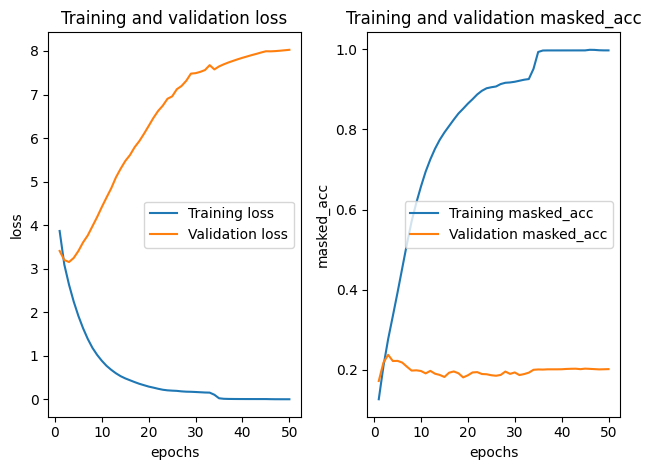

3.15500807762146 The best number of epocs for the validation loss is 3
0.23772819340229034 The best number of epocs for the validation accuracy is 3


In [24]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 6
NUM_DECODERS = 6
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50


2024-07-16 00:35:37.734525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 110s 289ms/step - loss: 4.4522 - masked_acc: 0.0736 - val_loss: 3.4322 - val_masked_acc: 0.1685 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - loss: 3.2615 - masked_acc: 0.1856 - val_loss: 3.2552 - val_masked_acc: 0.2000 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 235ms/step - loss: 2.8630 - masked_acc: 0.2432 - val_loss: 3.1674 - val_masked_acc: 0.2295 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - loss: 2.4651 - masked_acc: 0.3058 - val_loss: 3.2344 - val_masked_acc: 0.2261 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - loss: 2.1244 - masked_acc: 0.3597 - val_loss: 3.3526 - val_masked_acc: 0.2318 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - loss: 1.8256 - masked_acc: 0.4127 - val_loss: 3.5172 - val_masked_acc: 0.2240 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 236ms/step -

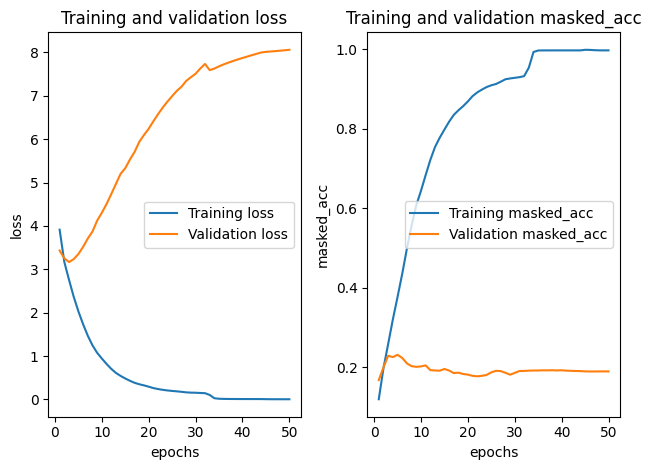

3.1674225330352783 The best number of epocs for the validation loss is 3
0.23181374371051788 The best number of epocs for the validation accuracy is 5


In [22]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 4
NUM_DECODERS = 4
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 66s 189ms/step - loss: 4.6995 - masked_acc: 0.0587 - val_loss: 3.5060 - val_masked_acc: 0.1632 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 151ms/step - loss: 3.3609 - masked_acc: 0.1746 - val_loss: 3.3473 - val_masked_acc: 0.1805 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - loss: 3.0657 - masked_acc: 0.2122 - val_loss: 3.2566 - val_masked_acc: 0.2009 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - loss: 2.7717 - masked_acc: 0.2589 - val_loss: 3.2188 - val_masked_acc: 0.2220 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - loss: 2.4588 - masked_acc: 0.3144 - val_loss: 3.2710 - val_masked_acc: 0.2295 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - loss: 2.1610 - masked_acc: 0.3648 - val_loss: 3.3757 - val_masked_acc: 0.2285 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 34s 14

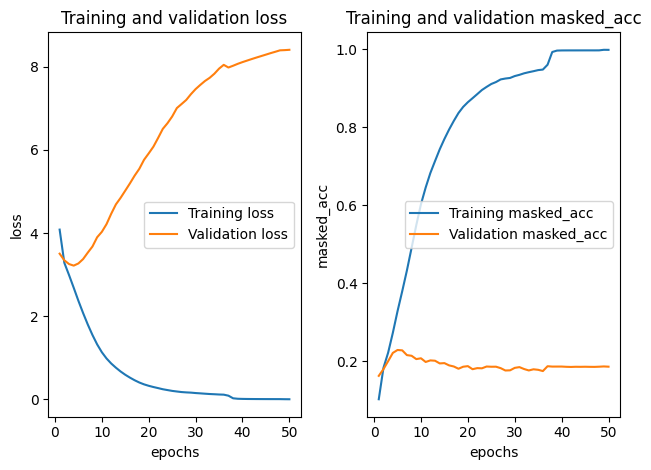

3.2187960147857666 The best number of epocs for the validation loss is 4
0.22946351766586304 The best number of epocs for the validation accuracy is 5


In [23]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-15 02:00:00)

Identify the best intermediate dimension from 256, 512, 1024.

#### Result

#### Next

Epoch 1/50


2024-07-15 02:03:37.544353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - loss: 5.0289 - masked_acc: 0.0452 - val_loss: 3.6850 - val_masked_acc: 0.1425 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - loss: 3.5373 - masked_acc: 0.1574 - val_loss: 3.4296 - val_masked_acc: 0.1710 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - loss: 3.2375 - masked_acc: 0.1927 - val_loss: 3.3441 - val_masked_acc: 0.1849 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 3.0221 - masked_acc: 0.2240 - val_loss: 3.2927 - val_masked_acc: 0.1980 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 2.8122 - masked_acc: 0.2560 - val_loss: 3.2996 - val_masked_acc: 0.2109 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 2.5916 - masked_acc: 0.2950 - val_loss: 3.2954 - val_masked_acc: 0.2132 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - 

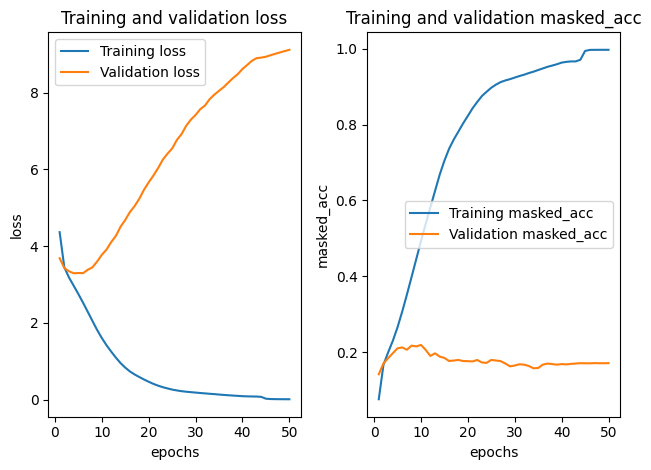

3.292686939239502 The best number of epocs for the validation loss is 4
0.2198389619588852 The best number of epocs for the validation accuracy is 10


In [22]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - loss: 5.0307 - masked_acc: 0.0428 - val_loss: 3.6869 - val_masked_acc: 0.1435 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 3.5360 - masked_acc: 0.1578 - val_loss: 3.4251 - val_masked_acc: 0.1702 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 3.2289 - masked_acc: 0.1931 - val_loss: 3.3410 - val_masked_acc: 0.1842 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 3.0129 - masked_acc: 0.2241 - val_loss: 3.2865 - val_masked_acc: 0.1962 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 2.8034 - masked_acc: 0.2561 - val_loss: 3.3252 - val_masked_acc: 0.2058 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 2.5771 - masked_acc: 0.2984 - val_loss: 3.3060 - val_masked_acc: 0.2151 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 10

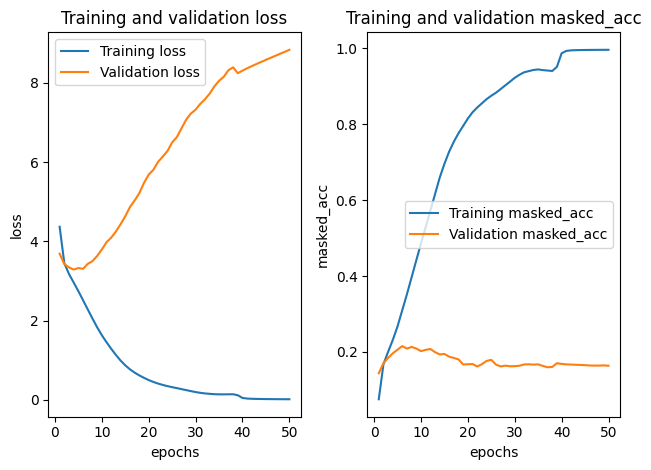

3.2864797115325928 The best number of epocs for the validation loss is 4
0.21513327956199646 The best number of epocs for the validation accuracy is 6


In [23]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - loss: 5.0372 - masked_acc: 0.0530 - val_loss: 3.7030 - val_masked_acc: 0.1381 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - loss: 3.5459 - masked_acc: 0.1564 - val_loss: 3.4236 - val_masked_acc: 0.1716 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 3.2251 - masked_acc: 0.1951 - val_loss: 3.3378 - val_masked_acc: 0.1874 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - loss: 3.0066 - masked_acc: 0.2263 - val_loss: 3.3004 - val_masked_acc: 0.1963 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - loss: 2.7966 - masked_acc: 0.2590 - val_loss: 3.3043 - val_masked_acc: 0.2114 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 2.5700 - masked_acc: 0.3003 - val_loss: 3.3103 - val_masked_acc: 0.2147 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 10

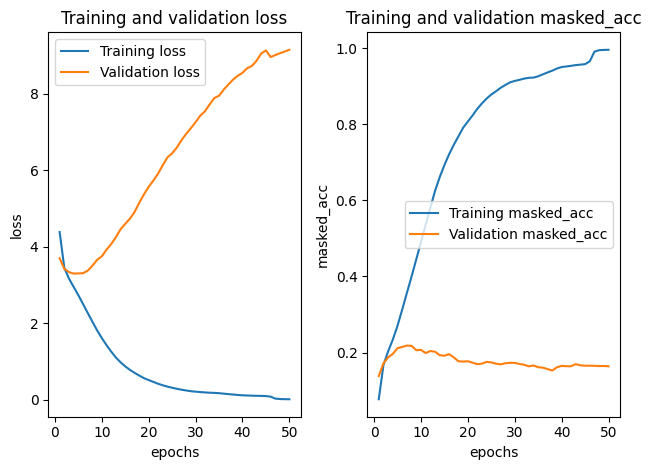

3.3004415035247803 The best number of epocs for the validation loss is 4
0.21818313002586365 The best number of epocs for the validation accuracy is 7


In [24]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 256
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - loss: 5.0287 - masked_acc: 0.0497 - val_loss: 3.7087 - val_masked_acc: 0.1416 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - loss: 3.5540 - masked_acc: 0.1567 - val_loss: 3.4234 - val_masked_acc: 0.1715 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - loss: 3.2280 - masked_acc: 0.1931 - val_loss: 3.3389 - val_masked_acc: 0.1862 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 3.0024 - masked_acc: 0.2265 - val_loss: 3.2828 - val_masked_acc: 0.2002 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 2.7775 - masked_acc: 0.2639 - val_loss: 3.3123 - val_masked_acc: 0.2074 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - loss: 2.5453 - masked_acc: 0.3043 - val_loss: 3.3163 - val_masked_acc: 0.2123 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 10

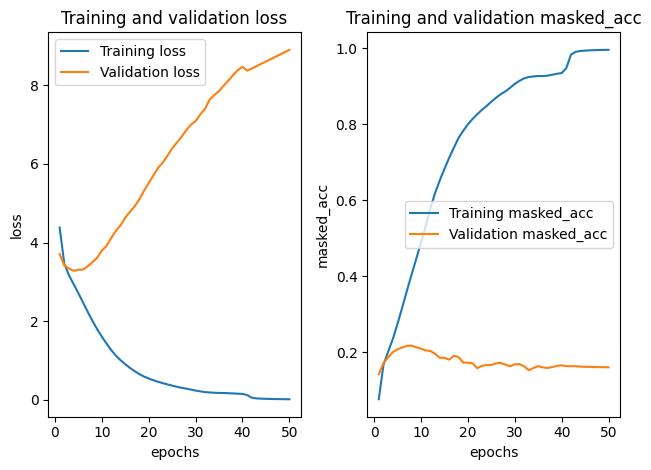

3.282804489135742 The best number of epocs for the validation loss is 4
0.21716365218162537 The best number of epocs for the validation accuracy is 8


In [25]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 128
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 43s 139ms/step - loss: 5.0363 - masked_acc: 0.0381 - val_loss: 3.6993 - val_masked_acc: 0.1420 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - loss: 3.5410 - masked_acc: 0.1580 - val_loss: 3.4226 - val_masked_acc: 0.1718 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - loss: 3.2249 - masked_acc: 0.1929 - val_loss: 3.3513 - val_masked_acc: 0.1851 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - loss: 3.0084 - masked_acc: 0.2223 - val_loss: 3.3076 - val_masked_acc: 0.1997 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 2.7889 - masked_acc: 0.2608 - val_loss: 3.2947 - val_masked_acc: 0.2137 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - loss: 2.5514 - masked_acc: 0.3044 - val_loss: 3.3258 - val_masked_acc: 0.2128 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 10

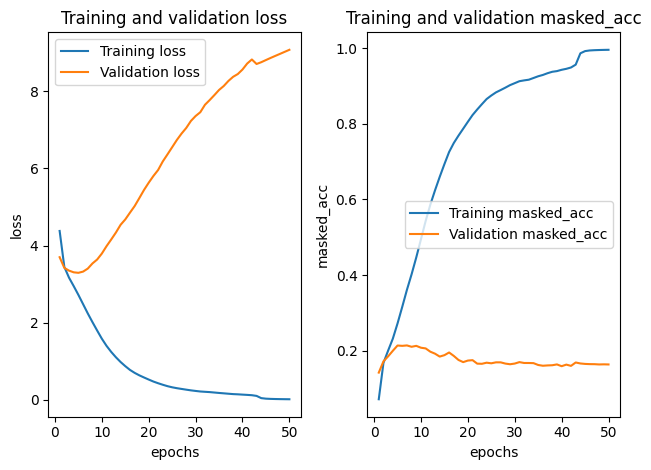

3.294699192047119 The best number of epocs for the validation loss is 5
0.21388421952724457 The best number of epocs for the validation accuracy is 7


In [26]:
# The maximum vocabulary size = 31907
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 64
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-13 15:15:00)

The batch size 64.

#### Result

#### Next

Epoch 1/50


2024-07-13 17:16:17.311635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - loss: 4.7332 - masked_acc: 0.0605 - val_loss: 3.4717 - val_masked_acc: 0.1505 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 3.4232 - masked_acc: 0.1655 - val_loss: 3.2560 - val_masked_acc: 0.1749 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 3.1670 - masked_acc: 0.1937 - val_loss: 3.1644 - val_masked_acc: 0.1870 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 2.9782 - masked_acc: 0.2200 - val_loss: 3.1016 - val_masked_acc: 0.1998 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 2.7903 - masked_acc: 0.2474 - val_loss: 3.0657 - val_masked_acc: 0.2136 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 2.5962 - masked_acc: 0.2801 - val_loss: 3.0581 - val_masked_acc: 0.2200 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - loss: 2

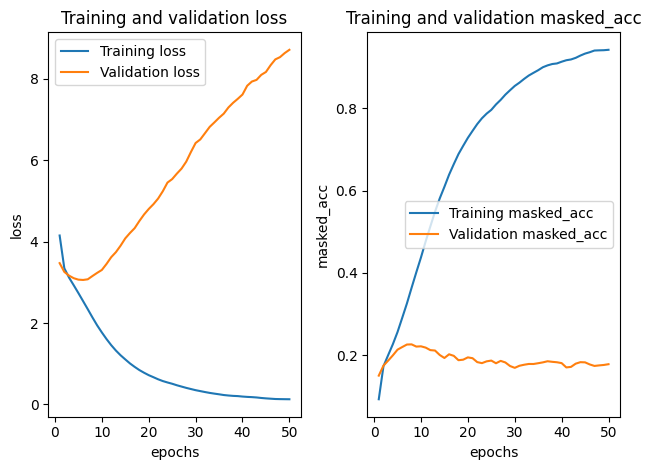

3.05808687210083 The best number of epocs for the validation loss is 6
0.22648921608924866 The best number of epocs for the validation accuracy is 8


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-13 15:15:00)

#### Result

#### Next

The batch size should be smaller to 64.

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 265ms/step - loss: 5.5057 - masked_acc: 0.0370 - val_loss: 4.1270 - val_masked_acc: 0.0714 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 4.0685 - masked_acc: 0.0963 - val_loss: 3.6933 - val_masked_acc: 0.1275 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - loss: 3.6463 - masked_acc: 0.1387 - val_loss: 3.4229 - val_masked_acc: 0.1554 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step - loss: 3.3724 - masked_acc: 0.1726 - val_loss: 3.3078 - val_masked_acc: 0.1689 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - loss: 3.2203 - masked_acc: 0.1902 - val_loss: 3.2502 - val_masked_acc: 0.1766 - learning_rate: 0.0010
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 3.1075 - masked_acc: 0.2035 - val_loss: 3.2278 - val_masked_acc: 0.1804 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - los

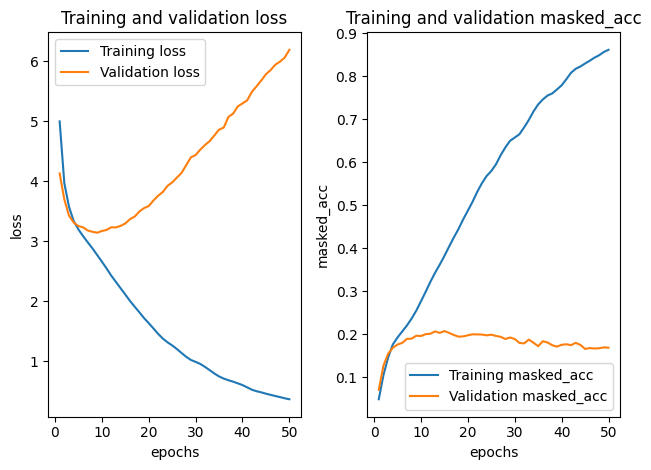

3.1388354301452637 The best number of epocs for the validation loss is 9
0.20788699388504028 The best number of epocs for the validation accuracy is 15


In [23]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 256
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

In [27]:
def evaluate(train_ds, validation_ds, test_ds):
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=BATCH_SIZE,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    )
    model.evaluate(test_ds)

evaluate(
    train_ds=train_ds,
    validation_ds=validation_ds,
    test_ds=test_ds,
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 6.3018 - masked_acc: 0.1572


### Note (Experiment Date: 2024-07-13 15:00:53)

First training.

#### Result

Fast. But, overfitting.

#### Next

The batch size to 256.

Epoch 1/50


2024-07-13 15:00:53.622382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - loss: 5.1045 - masked_acc: 0.0465 - val_loss: 3.8141 - val_masked_acc: 0.1149 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 3.7117 - masked_acc: 0.1346 - val_loss: 3.3768 - val_masked_acc: 0.1654 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 3.3258 - masked_acc: 0.1774 - val_loss: 3.2523 - val_masked_acc: 0.1744 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 3.1508 - masked_acc: 0.1968 - val_loss: 3.1817 - val_masked_acc: 0.1827 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 3.0032 - masked_acc: 0.2162 - val_loss: 3.1380 - val_masked_acc: 0.1914 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 2.8589 - masked_acc: 0.2391 - val_loss: 3.1439 - val_masked_acc: 0.2004 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - 

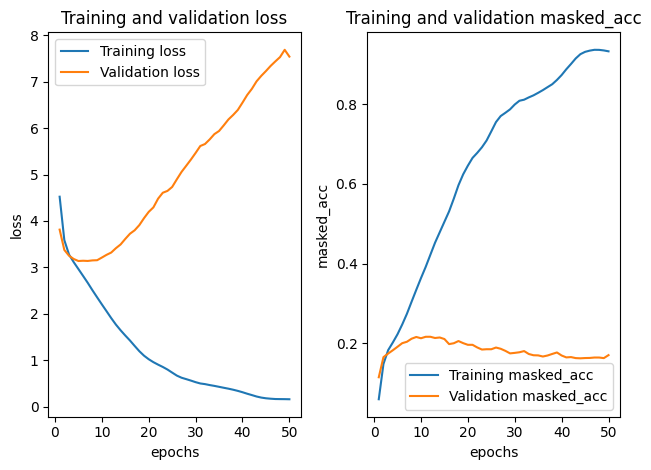

3.138007879257202 The best number of epocs for the validation loss is 5
0.2164759784936905 The best number of epocs for the validation accuracy is 12


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 128
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

In [24]:
SENTENCES = [
    """By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to be interesting' Trio: Westwood, his son and Poulter were snapped in this selfie at Royal Liverpool during practice . The team: Westwood uploaded this photograph to Instagram after his son convinced him to join . Giving in: Westwood said his son convinced him to join the social networking website . The Open starts on Thursday, and sees Poulter tee off at 9.37am with Westwood at 2.38pm. The latter, though, may be under added pressure after Europe's Ryder Cup captain Paul McGinley urged the 41-year-old to up his game in Liverpool. 'We all know Lee has the pedigree,' said McGinley. 'If you look back at the Ryder Cup since 1997, he has been the one constant pillar of all our success during that time. 'I'm a huge fan, and I'm certainly not looking to rip up the template. But I have to justify every decision I make, so he has to show me some form.' Hit and miss: Europe's Ryder Cup captain Paul McGinley says Westwood must 'show me some form' 6.25am: David Howell (ENG), David Duval (USA), Robert Krlsson (SWE) 6.36am: Dawie van der Walt (RSA), Cameron Tringale (USA), Masanori Kobayashi (JPN) 6.47am: Chris Wood (ENG), Matt Jones (AUS), Bernd Wiesberger (AUT) 6.58am: Erik Compton (USA), Kim Hyung-sung (KOR), Marc Leishman (AUS) 7.09am: Koumei Oda (JPN), Ben Martin (USA), Anirban Lahiri (IND) 7.20am: Kiradech Aphibarnrat (THA), Brooks Koepka (USA), Edoardo Molinari (ITA) 7.31am: Branden Grace (RSA), Freddie Jacobson (SWE), Ashley Chesters (ENG) 7.42am: Justin Leonard (USA), Ben Curtis (USA), Paul Lawrie (SCO) 7.53am: Francesco Molinari (ITA), Ryan Moore (USA), Thorbjorn Olesen (DEN) 8.04am: Matteo Manassero (ITA), Bradley Neil (SCO), Mikko Ilonen (FIN) 8.15am: Thomas Bjorn (DEN), Patrick Reed (USA), Stewart Cink (USA) 8.26am: Ben Watson (USA), Jim Furyk (USA), Darren Clarke (NIR) 8.37am: Luke Donald (ENG), Rickie Fowler (USA), Sergio Garcia (ESP) 8.53am: Harris English (USA), Paul Casey (ENG), Matt Every (USA) 9.04am: Tiger Woods (USA), Angel Cabera (ARG), Henrik Stenson (SWE) 9.15am: Charl Schwartzel (RSA), Padraig Harrington (IRL), KJ Choi (KOR) 9.26am: Rory McIlroy (NIR), Hideki Matsuyama (JPN), Jordan Spieth (USA) 9.37am: Ian Poulter (ENG), Dustin Johnson (USA), Jimmy Walker (USA) 9.48am: Graeme McDowell (NIR), Matt Kuchar (USA), Louis Oosthuizen (RSA) 9.59am: Stephen Gallacher (SCO), Hunter Mahan (USA), Victor Dubuisson (FRA) 10.10am: Sir Nick Faldo (ENG), Todd Hamilton (USA), Mark Calcavecchia (USA) 10.21am: Ryan Palmer (USA), Brett Rumford (AUS), Tomohiro Kondo (JPN) 10.32am: John Singleton (ENG), Peter UIhlein (USA), Marc Warren (SCO) 10.43am: Paul McKechnie (SCO), Kristoffer Broberg (SWE), Juvic Pagunsan (PHI) 10.54am: Rhein Gibon (AUS), Brian Harman (USA), Kim Hyung-tae (KOR), . 11.05am: Chris Hanson (ENG), Oscar Floren (SWE), Yoshinobu Tsukada (JPN) 11.26am: James McLeary (SCO), Matthew Southgate (ENG), Hiroshi Iwata (JPN) 11.37am: Roberto Castro (USA), Victor Riu (FRA), Tyrrell Hatton (ENG) 11.48am: Jang Dong-kyu (KOR), Nick Watney (USA), Shawn Stefani (USA) 11.59am: D A Points (USA), Ye Yang (KOR), Brendan Steele (USA) 12.10pm: Scott Stallings (USA), Pablo Larrazabal (ESP), Bryden Macpherson (AUS) 12.21pm: George Coetzee (RSA), Charley Hoffman (USA), Michael Hoey (NIR) 12.32pm: Kevin Streelman (USA), Brendon de Jonge (ZIM), Brendon Todd (USA) 12.43pm: Gary Woodland (USA), Sandy Lyle (SCO), Kevin Stadler (USA) 12.54pm: Brandt Snedeker (USA), Graham Delaet (CAN), Pan Cheng-tsung (TPE) 1.05pm: Boo Weekley (USA), Danny Willett (ENG), Wu Ashun (CHN) 1.16pm: JB Holmes (USA), Jonas Blixt (SWE), Chris Kirk (USA) 1.27pm: Miguel Angel Jiminez (ESP), Bill Haas (USA), Thongchai Jaidee (THA) 1.38pm: Martin Kaymer (GER), Jason Day (AUS), Zach Johnson (USA) 1.54pm: Webb Simpson (USA), Jamie Donaldson (WAL), Yusaku Miyazato (JPN) 2.05pm: Phil Mickelson (USA), Ernie Els (RSA), Bubba Watson (USA) 2.16pm: Gonzalo Fernandez-Castano (ESP), Russell Henley (USA), Billy Horschel (USA) 2.27pm: Adam Scott (AUS), Justin Rose (ENG), Jason Dufne (USA) 2.38pm: Ryo Ishikawa (JPN), Lee Westwood (ENG), Keegan Bradley (USA) 2.49pm: Kevin Na (USA), Joost Luiten (HOL), John Senden (AUS) 3.00pm: John Daly (USA), Tommy Fleetwood (ENG), Ross Fisher (ENG) 3.11pm: Mark Wiebe (USA), Rafael Cabrera-bello (ESP), Paul Dunne (IRL) 3.22pm: Oliver Fisher (ENG), Chesson Hadley (USA), Shane Lowry (IRL) 3.33pm: George McNeill (USA), Richard Sterne (RSA), Chris Stroud (USA) 3.44pm: Gregory Bourdy (FRA), Jin Jeong (KOR), Matthew Baldwin (ENG) 3.55pm: Justin Walters (RSA), Rhys Enoch (WAL), Billy Hurley III (USA) 4.06pm: Christoper Rodgers (ENG), Scott Jamieson (SCO), An Byeong-hun (KOR)""",
    """The Catholic Church has taken a 'step in the right direction' by holding talks on how to provide better spiritual care to homosexual members, gay rights activists said today. Following Pope Francis' famous 'Who am I to judge?' comment on homosexuality last year,\xc2\xa0bishops have repeatedly spoken of the need to change the church's language towards gays from words of moral condemnation and judgment, to words of welcome and respect. Now\xc2\xa0for the first time a Vatican meeting is discussing gay and lesbian issues within the Church - a move described as 'a crack in the ice that we have been waiting for, for a very long time' by the Catholic gay rights group\xc2\xa0New Ways Ministry. Scroll down for video . Discussions: Pope Francis talks to prelates as he arrives for a morning session of a two-week synod on family issues, at the Vatican this morning. Among the issues the synod will debate will be how to provide better spiritual care to homosexual members . New era: The decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis (pictured today) Despite their apparent softening on the issue, the Vatican's top canon lawyer was keen to make clear that the ongoing discussions will not focus on changing the Church's\xc2\xa0doctrine on homosexuality, nor will it lead to an endorsement of gay marriage or even gay unions. But the decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis. On the other hand the last pope, Benedict XVI, penned some of the modern Catholic Church's key documents opposing homosexuality\xc2\xa0when he was head the Vatican's orthodoxy office in the 1980s. 'I think what we're seeing is a crack in the ice that we have been waiting for, for a very long time,' said Francis DeBernardo, executive director of New Ways Ministry. 'It's a sign of a first step.' Church teaching holds that gay acts are 'intrinsically disordered,' sinful and a 'serious depravity,' and that homosexual inclination is 'objectively disordered.'\xc2\xa0At the same time, it says homosexuals themselves must be treated with respect and compassion and not suffer discrimination. 'I know scores of people who have left the Catholic Church because of those words,' DeBernardo said. Progressive: The Vatican synod is discussing gay and lesbian issues within the Church for the first time. The move has been described as 'a crack in the ice' by the Catholic gay rights group New Ways Ministry . Emeritus Pope Benedict XVI penned some of the Vatican's key documents on gays when he headed the Vatican's orthodoxy office; a 1986 letter of his to bishops on providing pastoral care to gays insisted that any church program must clearly state 'that homosexual activity is immoral.' His 2003 document opposing same-sex unions made clear that 'there are absolutely no grounds for considering homosexual unions to be in any way similar or even remotely analogous to God's plan for marriage and family.' The Vatican's top canon lawyer, Cardinal Francesco Coccopalmerio, yesterday said that the Catholic Church would 'never' accept gay marriage or even bless a gay union. Despite that unbending position, there's no doubting that a shift in tone has occurred. Michael Brinkschroeder, co-president of the European Forum of LGBT Christian Groups, said \xc2\xa0it was clear that the synod won't change doctrine, but that the 'Francis effect' appeared to be trickling down to local bishops. Many had 'lost their fear' and are freer now to engage in dialogue with gays in a way they couldn't under the last two popes, he said. 'With Benedict vanished from the scene, Francis has given signals for bishops to start pastoral work and dialogue,' he said. Welcome: Vatican Swiss Guards  salute Pope Francis as he arrives for the synod earlier in the week . Pope\xc2\xa0Francis famously said 'Who am I to judge?' when asked in 2013 about rumors that a top priestly adviser had a gay lover. DeBernardo, of New Ways Ministry, said the next step is for gays to be at the table offering their testimony to bishops. No openly gay Catholics have addressed the closed-door synod, but two Catholic heterosexual couples have spoken about experiences of devout Catholics welcoming gays or trying to provide pastoral care for them. He said he was 'euphoric' that some bishops had said language such as 'intrinsically disordered' was wholly ineffective in bringing people closer to the church. Not so fast, say conservative Catholics. Hard-line Cardinal Raymond Burke, who heads the Vatican's high court, insisted that gay sex was and will remain 'intrinsically disordered' and children must be protected from thinking otherwise. He was responding to testimony from an Australian Catholic couple who told the synod about friends who welcomed their gay son and his partner to a Christmas party. 'That particular form of relationship should not be imposed upon family members, and especially upon impressionable children,' Burke told the conservative LifeSiteNews. 'And I urge parents or grandparents - whoever it may be - to be very, very prudent in this matter and not to scandalize their children or grandchildren.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend ."""
]
predict_model(
    model=model,
    examples=SENTENCES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
print("")

ORIGINAL SENTENCE:  By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to 

In [25]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

***

### Note (Experiment Date: 2024-07-13 02:09:55)

10% dataset

-- | highlights_count | article_count
--- | --- | ---
mean | 51.478118 | 691.626074
25% | 38 | 443
50% | 48 | 632
75% | 60 | 877
max | 1296 | 2347

When the parameter `ENCODER_SEQUENCE_LENGTH` is 1024, that causes the OOM error. Therefore, the following parameters are instead used.

- ENCODER_SEQUENCE_LENGTH = 512
- DECODER_SEQUENCE_LENGTH = 64

#### Result

#### Next


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 512 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 512 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 # 1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-13 02:09:55)

10% dataset

-- | highlights_count | article_count
--- | --- | ---
mean | 51.478118 | 691.626074
25% | 38 | 443
50% | 48 | 632
75% | 60 | 877
max | 1296 | 2347

Changed seq lengths to cover 75%.

- ENCODER_SEQUENCE_LENGTH = 1024
- DECODER_SEQUENCE_LENGTH = 64

#### Result

```
Local rendezvous is aborting with status: RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[64,12,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator
```

#### Next

The `ENCODER_SEQUENCE_LENGTH` parameter is changed to 512 from 1024.

Some experiments cannot be executed according to the OOM error. It might be better to use other datasets.

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 512 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 64 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50


2024-07-13 02:09:55.198576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 438s 949ms/step - loss: 5.4204 - masked_acc: 0.0715 - val_loss: 5.0321 - val_masked_acc: 0.1321 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 403s 895ms/step - loss: 4.5899 - masked_acc: 0.1333 - val_loss: 4.7563 - val_masked_acc: 0.1488 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 421s 936ms/step - loss: 4.3435 - masked_acc: 0.1488 - val_loss: 4.6175 - val_masked_acc: 0.1578 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - loss: 4.1790 - masked_acc: 0.1597 - val_loss: 4.5413 - val_masked_acc: 0.1644 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - loss: 4.0544 - masked_acc: 0.1685 - val_loss: 4.5075 - val_masked_acc: 0.1673 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 412s 915ms/step - loss: 3.9523 - masked_acc: 0.1755 - val_loss: 4.4771 - val_masked_acc: 0.1689 - learning_rate: 0.0010
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 401s 893ms/step -

2024-07-13 06:51:24.430463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[64,12,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator
	 [[{{function_node __inference_one_step_on_data_17824}}{{node gradient_tape/transformer_encoder_decoder_model_1/encoder_0_1/self_attention_layer_1/MatMul_1/Sum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.



ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/transformer_encoder_decoder_model_1/encoder_0_1/self_attention_layer_1/MatMul_1/Sum defined at (most recent call last):
  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/yb/ls4k026509ndv565p_y41swh0000gn/T/ipykernel_28578/1491968942.py", line 21, in <module>

  File "/var/folders/yb/ls4k026509ndv565p_y41swh0000gn/T/ipykernel_28578/3408643372.py", line 71, in build_model

  File "/var/folders/yb/ls4k026509ndv565p_y41swh0000gn/T/ipykernel_28578/2076776028.py", line 30, in run_training

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

OOM when allocating tensor with shape[64,12,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator
	 [[{{node gradient_tape/transformer_encoder_decoder_model_1/encoder_0_1/self_attention_layer_1/MatMul_1/Sum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_18129]

### Note (Experiment Date: 2024-07-12 23:01:02)

Just build a model.

Epoch 1/50


2024-07-12 23:01:02.807872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 247s 524ms/step - loss: 1.4816 - masked_acc: 0.0698 - val_loss: 1.3870 - val_masked_acc: 0.1321 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 233s 518ms/step - loss: 1.2511 - masked_acc: 0.1326 - val_loss: 1.3142 - val_masked_acc: 0.1476 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 231s 513ms/step - loss: 1.1837 - masked_acc: 0.1478 - val_loss: 1.2794 - val_masked_acc: 0.1572 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 228s 508ms/step - loss: 1.1362 - masked_acc: 0.1603 - val_loss: 1.2576 - val_masked_acc: 0.1630 - learning_rate: 0.0010
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 228s 507ms/step - loss: 1.0984 - masked_acc: 0.1697 - val_loss: 1.2448 - val_masked_acc: 0.1667 - learning_rate: 0.0010
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 226s 502ms/step - loss: 1.0659 - masked_acc: 0.1777 - val_loss: 1.2371 - val_masked_acc: 0.1691 - learning_rate: 0.0010
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 217s 482ms/

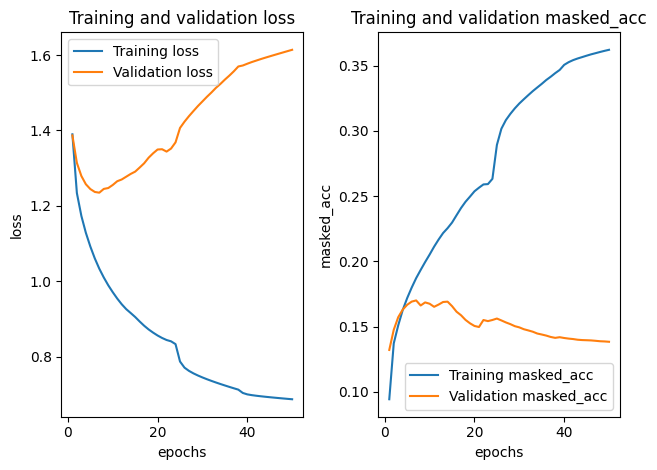

1.2351101636886597 The best number of epocs for the validation loss is 7
0.17003488540649414 The best number of epocs for the validation accuracy is 7


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 512 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

In [23]:
SENTENCES = [
    """By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to be interesting' Trio: Westwood, his son and Poulter were snapped in this selfie at Royal Liverpool during practice . The team: Westwood uploaded this photograph to Instagram after his son convinced him to join . Giving in: Westwood said his son convinced him to join the social networking website . The Open starts on Thursday, and sees Poulter tee off at 9.37am with Westwood at 2.38pm. The latter, though, may be under added pressure after Europe's Ryder Cup captain Paul McGinley urged the 41-year-old to up his game in Liverpool. 'We all know Lee has the pedigree,' said McGinley. 'If you look back at the Ryder Cup since 1997, he has been the one constant pillar of all our success during that time. 'I'm a huge fan, and I'm certainly not looking to rip up the template. But I have to justify every decision I make, so he has to show me some form.' Hit and miss: Europe's Ryder Cup captain Paul McGinley says Westwood must 'show me some form' 6.25am: David Howell (ENG), David Duval (USA), Robert Krlsson (SWE) 6.36am: Dawie van der Walt (RSA), Cameron Tringale (USA), Masanori Kobayashi (JPN) 6.47am: Chris Wood (ENG), Matt Jones (AUS), Bernd Wiesberger (AUT) 6.58am: Erik Compton (USA), Kim Hyung-sung (KOR), Marc Leishman (AUS) 7.09am: Koumei Oda (JPN), Ben Martin (USA), Anirban Lahiri (IND) 7.20am: Kiradech Aphibarnrat (THA), Brooks Koepka (USA), Edoardo Molinari (ITA) 7.31am: Branden Grace (RSA), Freddie Jacobson (SWE), Ashley Chesters (ENG) 7.42am: Justin Leonard (USA), Ben Curtis (USA), Paul Lawrie (SCO) 7.53am: Francesco Molinari (ITA), Ryan Moore (USA), Thorbjorn Olesen (DEN) 8.04am: Matteo Manassero (ITA), Bradley Neil (SCO), Mikko Ilonen (FIN) 8.15am: Thomas Bjorn (DEN), Patrick Reed (USA), Stewart Cink (USA) 8.26am: Ben Watson (USA), Jim Furyk (USA), Darren Clarke (NIR) 8.37am: Luke Donald (ENG), Rickie Fowler (USA), Sergio Garcia (ESP) 8.53am: Harris English (USA), Paul Casey (ENG), Matt Every (USA) 9.04am: Tiger Woods (USA), Angel Cabera (ARG), Henrik Stenson (SWE) 9.15am: Charl Schwartzel (RSA), Padraig Harrington (IRL), KJ Choi (KOR) 9.26am: Rory McIlroy (NIR), Hideki Matsuyama (JPN), Jordan Spieth (USA) 9.37am: Ian Poulter (ENG), Dustin Johnson (USA), Jimmy Walker (USA) 9.48am: Graeme McDowell (NIR), Matt Kuchar (USA), Louis Oosthuizen (RSA) 9.59am: Stephen Gallacher (SCO), Hunter Mahan (USA), Victor Dubuisson (FRA) 10.10am: Sir Nick Faldo (ENG), Todd Hamilton (USA), Mark Calcavecchia (USA) 10.21am: Ryan Palmer (USA), Brett Rumford (AUS), Tomohiro Kondo (JPN) 10.32am: John Singleton (ENG), Peter UIhlein (USA), Marc Warren (SCO) 10.43am: Paul McKechnie (SCO), Kristoffer Broberg (SWE), Juvic Pagunsan (PHI) 10.54am: Rhein Gibon (AUS), Brian Harman (USA), Kim Hyung-tae (KOR), . 11.05am: Chris Hanson (ENG), Oscar Floren (SWE), Yoshinobu Tsukada (JPN) 11.26am: James McLeary (SCO), Matthew Southgate (ENG), Hiroshi Iwata (JPN) 11.37am: Roberto Castro (USA), Victor Riu (FRA), Tyrrell Hatton (ENG) 11.48am: Jang Dong-kyu (KOR), Nick Watney (USA), Shawn Stefani (USA) 11.59am: D A Points (USA), Ye Yang (KOR), Brendan Steele (USA) 12.10pm: Scott Stallings (USA), Pablo Larrazabal (ESP), Bryden Macpherson (AUS) 12.21pm: George Coetzee (RSA), Charley Hoffman (USA), Michael Hoey (NIR) 12.32pm: Kevin Streelman (USA), Brendon de Jonge (ZIM), Brendon Todd (USA) 12.43pm: Gary Woodland (USA), Sandy Lyle (SCO), Kevin Stadler (USA) 12.54pm: Brandt Snedeker (USA), Graham Delaet (CAN), Pan Cheng-tsung (TPE) 1.05pm: Boo Weekley (USA), Danny Willett (ENG), Wu Ashun (CHN) 1.16pm: JB Holmes (USA), Jonas Blixt (SWE), Chris Kirk (USA) 1.27pm: Miguel Angel Jiminez (ESP), Bill Haas (USA), Thongchai Jaidee (THA) 1.38pm: Martin Kaymer (GER), Jason Day (AUS), Zach Johnson (USA) 1.54pm: Webb Simpson (USA), Jamie Donaldson (WAL), Yusaku Miyazato (JPN) 2.05pm: Phil Mickelson (USA), Ernie Els (RSA), Bubba Watson (USA) 2.16pm: Gonzalo Fernandez-Castano (ESP), Russell Henley (USA), Billy Horschel (USA) 2.27pm: Adam Scott (AUS), Justin Rose (ENG), Jason Dufne (USA) 2.38pm: Ryo Ishikawa (JPN), Lee Westwood (ENG), Keegan Bradley (USA) 2.49pm: Kevin Na (USA), Joost Luiten (HOL), John Senden (AUS) 3.00pm: John Daly (USA), Tommy Fleetwood (ENG), Ross Fisher (ENG) 3.11pm: Mark Wiebe (USA), Rafael Cabrera-bello (ESP), Paul Dunne (IRL) 3.22pm: Oliver Fisher (ENG), Chesson Hadley (USA), Shane Lowry (IRL) 3.33pm: George McNeill (USA), Richard Sterne (RSA), Chris Stroud (USA) 3.44pm: Gregory Bourdy (FRA), Jin Jeong (KOR), Matthew Baldwin (ENG) 3.55pm: Justin Walters (RSA), Rhys Enoch (WAL), Billy Hurley III (USA) 4.06pm: Christoper Rodgers (ENG), Scott Jamieson (SCO), An Byeong-hun (KOR)""",
    """The Catholic Church has taken a 'step in the right direction' by holding talks on how to provide better spiritual care to homosexual members, gay rights activists said today. Following Pope Francis' famous 'Who am I to judge?' comment on homosexuality last year,\xc2\xa0bishops have repeatedly spoken of the need to change the church's language towards gays from words of moral condemnation and judgment, to words of welcome and respect. Now\xc2\xa0for the first time a Vatican meeting is discussing gay and lesbian issues within the Church - a move described as 'a crack in the ice that we have been waiting for, for a very long time' by the Catholic gay rights group\xc2\xa0New Ways Ministry. Scroll down for video . Discussions: Pope Francis talks to prelates as he arrives for a morning session of a two-week synod on family issues, at the Vatican this morning. Among the issues the synod will debate will be how to provide better spiritual care to homosexual members . New era: The decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis (pictured today) Despite their apparent softening on the issue, the Vatican's top canon lawyer was keen to make clear that the ongoing discussions will not focus on changing the Church's\xc2\xa0doctrine on homosexuality, nor will it lead to an endorsement of gay marriage or even gay unions. But the decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis. On the other hand the last pope, Benedict XVI, penned some of the modern Catholic Church's key documents opposing homosexuality\xc2\xa0when he was head the Vatican's orthodoxy office in the 1980s. 'I think what we're seeing is a crack in the ice that we have been waiting for, for a very long time,' said Francis DeBernardo, executive director of New Ways Ministry. 'It's a sign of a first step.' Church teaching holds that gay acts are 'intrinsically disordered,' sinful and a 'serious depravity,' and that homosexual inclination is 'objectively disordered.'\xc2\xa0At the same time, it says homosexuals themselves must be treated with respect and compassion and not suffer discrimination. 'I know scores of people who have left the Catholic Church because of those words,' DeBernardo said. Progressive: The Vatican synod is discussing gay and lesbian issues within the Church for the first time. The move has been described as 'a crack in the ice' by the Catholic gay rights group New Ways Ministry . Emeritus Pope Benedict XVI penned some of the Vatican's key documents on gays when he headed the Vatican's orthodoxy office; a 1986 letter of his to bishops on providing pastoral care to gays insisted that any church program must clearly state 'that homosexual activity is immoral.' His 2003 document opposing same-sex unions made clear that 'there are absolutely no grounds for considering homosexual unions to be in any way similar or even remotely analogous to God's plan for marriage and family.' The Vatican's top canon lawyer, Cardinal Francesco Coccopalmerio, yesterday said that the Catholic Church would 'never' accept gay marriage or even bless a gay union. Despite that unbending position, there's no doubting that a shift in tone has occurred. Michael Brinkschroeder, co-president of the European Forum of LGBT Christian Groups, said \xc2\xa0it was clear that the synod won't change doctrine, but that the 'Francis effect' appeared to be trickling down to local bishops. Many had 'lost their fear' and are freer now to engage in dialogue with gays in a way they couldn't under the last two popes, he said. 'With Benedict vanished from the scene, Francis has given signals for bishops to start pastoral work and dialogue,' he said. Welcome: Vatican Swiss Guards  salute Pope Francis as he arrives for the synod earlier in the week . Pope\xc2\xa0Francis famously said 'Who am I to judge?' when asked in 2013 about rumors that a top priestly adviser had a gay lover. DeBernardo, of New Ways Ministry, said the next step is for gays to be at the table offering their testimony to bishops. No openly gay Catholics have addressed the closed-door synod, but two Catholic heterosexual couples have spoken about experiences of devout Catholics welcoming gays or trying to provide pastoral care for them. He said he was 'euphoric' that some bishops had said language such as 'intrinsically disordered' was wholly ineffective in bringing people closer to the church. Not so fast, say conservative Catholics. Hard-line Cardinal Raymond Burke, who heads the Vatican's high court, insisted that gay sex was and will remain 'intrinsically disordered' and children must be protected from thinking otherwise. He was responding to testimony from an Australian Catholic couple who told the synod about friends who welcomed their gay son and his partner to a Christmas party. 'That particular form of relationship should not be imposed upon family members, and especially upon impressionable children,' Burke told the conservative LifeSiteNews. 'And I urge parents or grandparents - whoever it may be - to be very, very prudent in this matter and not to scandalize their children or grandchildren.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend ."""
]
predict_model(
    model=model,
    examples=SENTENCES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
print("")

ORIGINAL SENTENCE:  By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to 

In [24]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

### Note (Experiment Date: 2024-07-12 07:33:53)

10% dataset

- reduce_lr_callbacks is disabled
- USE_RESIDUAL = True

How much does the reduce learning rate callbacks contributes?

#### Result

- 15.8% decreased.

#### Next

- How much does Batch normalizer work?

Epoch 1/100


2024-07-12 07:33:53.464455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 158s 310ms/step - loss: 2.8788 - masked_acc: 0.0831 - val_loss: 2.6860 - val_masked_acc: 0.1427
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 137s 304ms/step - loss: 2.4177 - masked_acc: 0.1418 - val_loss: 2.5589 - val_masked_acc: 0.1552
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 301ms/step - loss: 2.2830 - masked_acc: 0.1572 - val_loss: 2.5010 - val_masked_acc: 0.1621
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 137s 303ms/step - loss: 2.1876 - masked_acc: 0.1690 - val_loss: 2.4656 - val_masked_acc: 0.1671
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 131s 291ms/step - loss: 2.1083 - masked_acc: 0.1789 - val_loss: 2.4511 - val_masked_acc: 0.1694
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 130s 288ms/step - loss: 2.0419 - masked_acc: 0.1877 - val_loss: 2.4494 - val_masked_acc: 0.1721
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 3425s 8s/step - loss: 1.9852 - masked_acc: 0.1958 - val_loss: 2.4577 - val_masked_acc: 0.1743
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 138s 305ms/ste

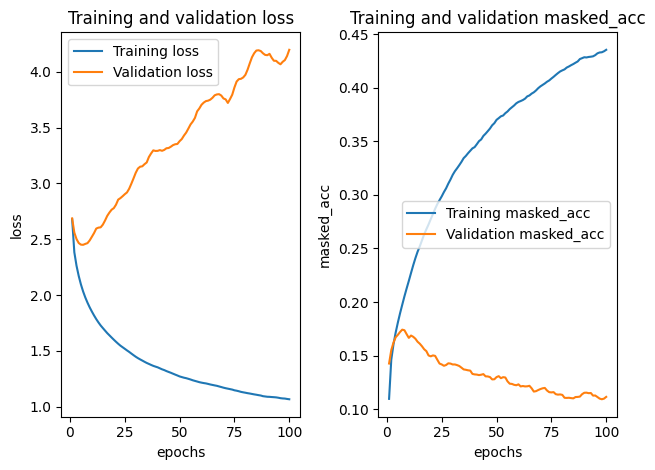

2.4494340419769287 The best number of epocs for the validation loss is 6
0.17425841093063354 The best number of epocs for the validation accuracy is 7


In [21]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-11 12:30:00)

10% dataset

- `USE_RESIDUAL = False`

#### Result

- 7.7% accuracy decreased.

#### Next

- Batch normalizer

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 172s 335ms/step - loss: 2.9255 - masked_acc: 0.0744 - val_loss: 2.7198 - val_masked_acc: 0.1375 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - loss: 2.4514 - masked_acc: 0.1378 - val_loss: 2.5860 - val_masked_acc: 0.1514 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - loss: 2.3109 - masked_acc: 0.1534 - val_loss: 2.5148 - val_masked_acc: 0.1612 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 208s 463ms/step - loss: 2.2141 - masked_acc: 0.1660 - val_loss: 2.4781 - val_masked_acc: 0.1677 - learning_rate: 0.0010
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 331ms/step - loss: 2.1368 - masked_acc: 0.1756 - val_loss: 2.4594 - val_masked_acc: 0.1708 - learning_rate: 0.0010
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 321ms/step - loss: 2.0721 - masked_acc: 0.1841 - val_loss: 2.4477 - val_masked_acc: 0.1732 - learning_rate: 0.0010
Epoch 7/100
449/449 ━━━━━━━━━━━━━━

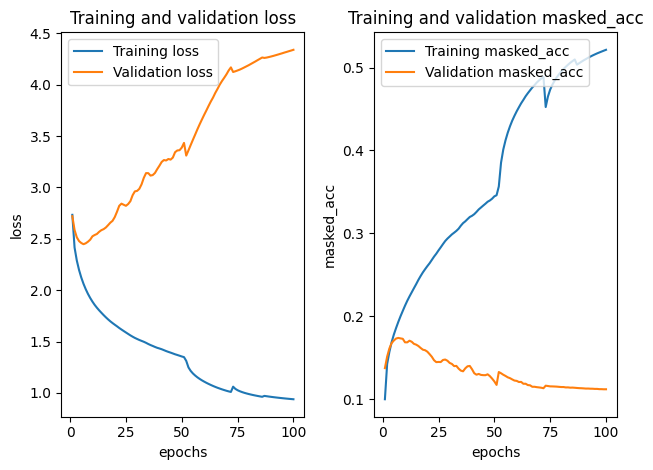

2.4477014541625977 The best number of epocs for the validation loss is 6
0.17393936216831207 The best number of epocs for the validation accuracy is 7


In [21]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-11 07:15:29)

10% dataset

- `callbacks=[reduce_lr_callbacks]`

new learning rate manage params

```diff
-    "    min_delta=0.03,\n",
+    "    min_delta=0.04,\n",
     "    cooldown=10,\n",
-    "    min_lr=5e-4, # 0.0005\n",
+    "    min_lr=2e-5, # 5e-4: 0.0005, 2e-5: 0.00002\n",
```

#### Result

- 9.1% accuracy improved.

#### Next

Confirm if the residual connection is necessary to improve with the better parameters of ReduceLROnPlateau.

Epoch 1/100


2024-07-11 07:15:29.851788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 160s 315ms/step - loss: 2.8767 - masked_acc: 0.0824 - val_loss: 2.6641 - val_masked_acc: 0.1438 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 140s 309ms/step - loss: 2.3961 - masked_acc: 0.1452 - val_loss: 2.5440 - val_masked_acc: 0.1588 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 137s 305ms/step - loss: 2.2561 - masked_acc: 0.1608 - val_loss: 2.4830 - val_masked_acc: 0.1667 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 308ms/step - loss: 2.1558 - masked_acc: 0.1726 - val_loss: 2.4520 - val_masked_acc: 0.1702 - learning_rate: 0.0010
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 308ms/step - loss: 2.0743 - masked_acc: 0.1831 - val_loss: 2.4426 - val_masked_acc: 0.1726 - learning_rate: 0.0010
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 302ms/step - loss: 2.0088 - masked_acc: 0.1920 - val_loss: 2.4475 - val_masked_acc: 0.1730 - learning_rate: 0.0010
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 132s 

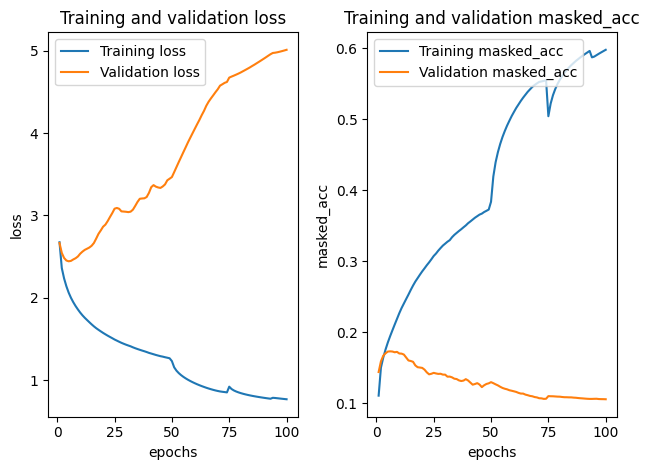

2.4425971508026123 The best number of epocs for the validation loss is 5
0.17297035455703735 The best number of epocs for the validation accuracy is 6


In [20]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-11 00:10:00)

10% dataset

- **`LAYER_NORM_EPSILON = 1e-5`**

Compare 2 `LAYER_NORM_EPSILON` of `1e-5` and `1e-3`

#### Result

- `1e-3` is better than `1e-5`.
    - 5 epoch faster improved
    - 0.3% accuracy improved

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 153s 297ms/step - loss: 2.8808 - masked_acc: 0.0826 - val_loss: 2.6808 - val_masked_acc: 0.1408 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - loss: 2.4172 - masked_acc: 0.1409 - val_loss: 2.5606 - val_masked_acc: 0.1538 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - loss: 2.2835 - masked_acc: 0.1561 - val_loss: 2.5009 - val_masked_acc: 0.1605 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - loss: 2.1879 - masked_acc: 0.1678 - val_loss: 2.4654 - val_masked_acc: 0.1677 - learning_rate: 0.0010
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 129s 286ms/step - loss: 2.1117 - masked_acc: 0.1772 - val_loss: 2.4521 - val_masked_acc: 0.1702 - learning_rate: 0.0010
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 285ms/step - loss: 2.0498 - masked_acc: 0.1857 - val_loss: 2.4500 - val_masked_acc: 0.1732 - learning_rate: 0.0010
Epoch 7/100
449/449 ━━━━━━━━━━━━━━

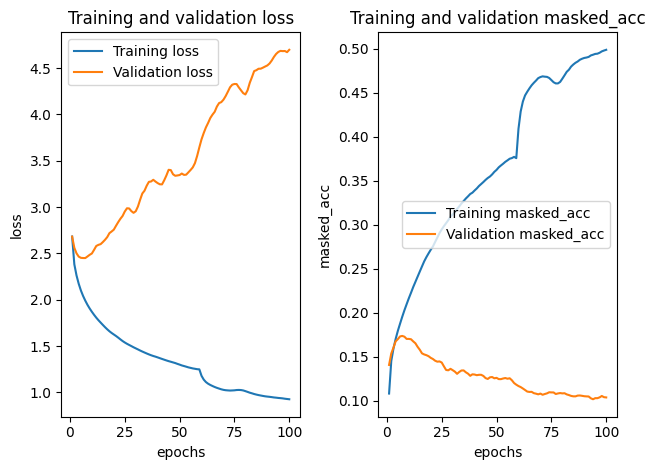

2.449758291244507 The best number of epocs for the validation loss is 7
0.17378853261470795 The best number of epocs for the validation accuracy is 7


In [22]:
# Subclassing API - 2 layers added training parameter on the call method, use residual
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-10 23:28:55)

10% dataset

- **`callbacks=[reduce_lr_callbacks]`**

Confirmation of how `callbacks=[reduce_lr_callbacks]` works well.

#### Result


Epoch 1/100


2024-07-10 23:28:55.826874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 157s 308ms/step - loss: 2.8851 - masked_acc: 0.0828 - val_loss: 2.6802 - val_masked_acc: 0.1417 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 137s 303ms/step - loss: 2.4112 - masked_acc: 0.1424 - val_loss: 2.5533 - val_masked_acc: 0.1561 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 138s 306ms/step - loss: 2.2701 - masked_acc: 0.1583 - val_loss: 2.4921 - val_masked_acc: 0.1636 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 298ms/step - loss: 2.1727 - masked_acc: 0.1704 - val_loss: 2.4629 - val_masked_acc: 0.1691 - learning_rate: 0.0010
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 299ms/step - loss: 2.0941 - masked_acc: 0.1804 - val_loss: 2.4475 - val_masked_acc: 0.1734 - learning_rate: 0.0010
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 301ms/step - loss: 2.0312 - masked_acc: 0.1889 - val_loss: 2.4480 - val_masked_acc: 0.1733 - learning_rate: 0.0010
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 134s 

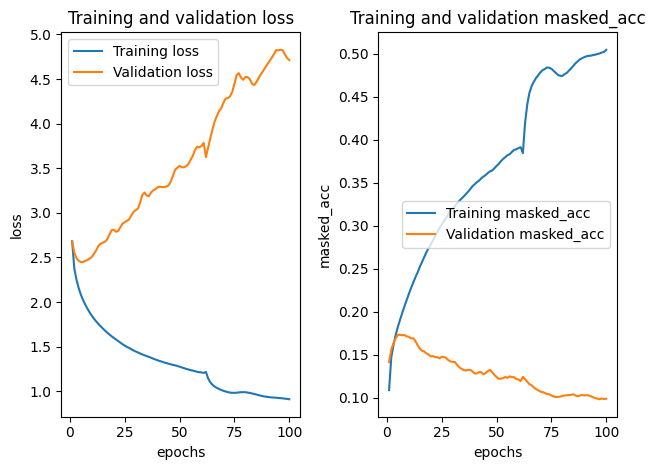

2.4474568367004395 The best number of epocs for the validation loss is 5
0.17343729734420776 The best number of epocs for the validation accuracy is 5


In [21]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-10 17:10:00)

10% dataset

- `layer_norm_epsilon=1e-03`
- NUM_HEADS = 12
- INTERMEDIATE_DIM = 2048

#### Result

2.9% accuracy improved.

The better parameters of the intermediate dimension and the number of heads are 2048 and 12, respectively. `1e-03` of the epsilon value is not confirmed to be better.

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 220s 436ms/step - loss: 3.3766 - masked_acc: 0.0391 - val_loss: 2.9855 - val_masked_acc: 0.1066
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 7881s 18s/step - loss: 2.6444 - masked_acc: 0.1130 - val_loss: 2.7019 - val_masked_acc: 0.1374
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 328ms/step - loss: 2.4410 - masked_acc: 0.1369 - val_loss: 2.5994 - val_masked_acc: 0.1482
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 322ms/step - loss: 2.3332 - masked_acc: 0.1481 - val_loss: 2.5427 - val_masked_acc: 0.1545
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 149s 330ms/step - loss: 2.2500 - masked_acc: 0.1574 - val_loss: 2.5054 - val_masked_acc: 0.1579
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 147s 326ms/step - loss: 2.1801 - masked_acc: 0.1654 - val_loss: 2.4761 - val_masked_acc: 0.1625
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 144s 318ms/step - loss: 2.1220 - masked_acc: 0.1718 - val_loss: 2.4693 - val_masked_acc: 0.1644
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 1

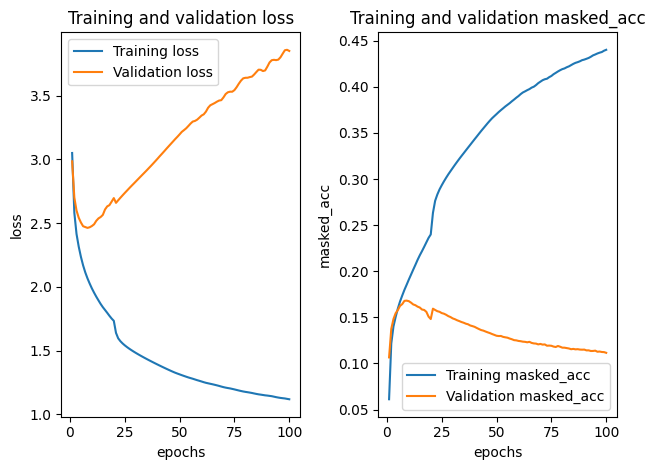

2.4630038738250732 The best number of epocs for the validation loss is 8
0.16815723478794098 The best number of epocs for the validation accuracy is 9


In [21]:
# Subclassing API - 2 layers added training parameter on the call method, use residual
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-10 13:35:02)

10% dataset

- **`NUM_ENCODERS = 2`**
- **`NUM_DECODERS = 2`**
- residual connection
- training parameter

#### Result

The best ever

- The residual connection seems effective.

Epoch 1/100


2024-07-10 13:35:02.618652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 159s 307ms/step - loss: 3.3849 - masked_acc: 0.0402 - val_loss: 2.9870 - val_masked_acc: 0.1057
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 319ms/step - loss: 2.6402 - masked_acc: 0.1139 - val_loss: 2.6962 - val_masked_acc: 0.1369
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step - loss: 2.4316 - masked_acc: 0.1374 - val_loss: 2.5952 - val_masked_acc: 0.1479
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 283ms/step - loss: 2.3226 - masked_acc: 0.1490 - val_loss: 2.5343 - val_masked_acc: 0.1558
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 127s 283ms/step - loss: 2.2381 - masked_acc: 0.1578 - val_loss: 2.4919 - val_masked_acc: 0.1603
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 124s 275ms/step - loss: 2.1701 - masked_acc: 0.1653 - val_loss: 2.4762 - val_masked_acc: 0.1626
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 125s 277ms/step - loss: 2.1144 - masked_acc: 0.1715 - val_loss: 2.4777 - val_masked_acc: 0.1627
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 131s 288ms/s

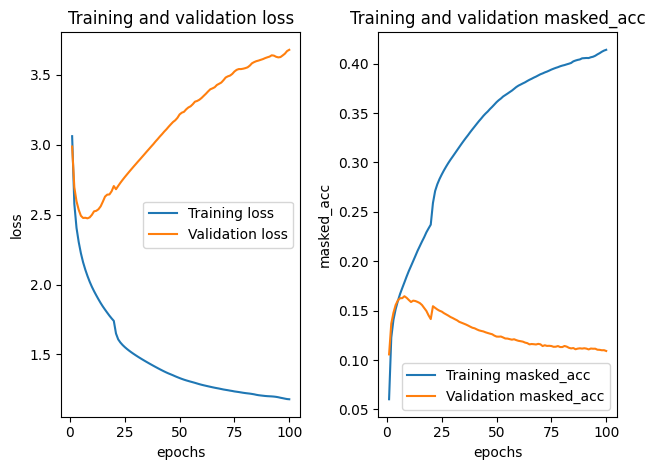

2.473731756210327 The best number of epocs for the validation loss is 8
0.16460198163986206 The best number of epocs for the validation accuracy is 8


In [20]:
# Subclassing API - 2 layers added training parameter on the call method, use residual
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-10 00:53:55)

10% dataset

- **`NUM_ENCODERS = 1~2`**
- **`NUM_DECODERS = 1~2`**
- training parameter on the call method

#### Result

- Improved 0.0281 accuracy.

Epoch 1/100


2024-07-10 00:53:55.152370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 286ms/step - loss: 3.4258 - masked_acc: 0.0297 - val_loss: 3.0726 - val_masked_acc: 0.0873
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 131s 288ms/step - loss: 2.7234 - masked_acc: 0.0981 - val_loss: 2.7557 - val_masked_acc: 0.1331
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 130s 289ms/step - loss: 2.4884 - masked_acc: 0.1315 - val_loss: 2.6356 - val_masked_acc: 0.1423
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 284ms/step - loss: 2.3744 - masked_acc: 0.1422 - val_loss: 2.5764 - val_masked_acc: 0.1491
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 279ms/step - loss: 2.2974 - masked_acc: 0.1503 - val_loss: 2.5375 - val_masked_acc: 0.1544
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 280ms/step - loss: 2.2330 - masked_acc: 0.1577 - val_loss: 2.5084 - val_masked_acc: 0.1590
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 123s 273ms/step - loss: 2.1756 - masked_acc: 0.1638 - val_loss: 2.4999 - val_masked_acc: 0.1602
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 123s 274ms/s

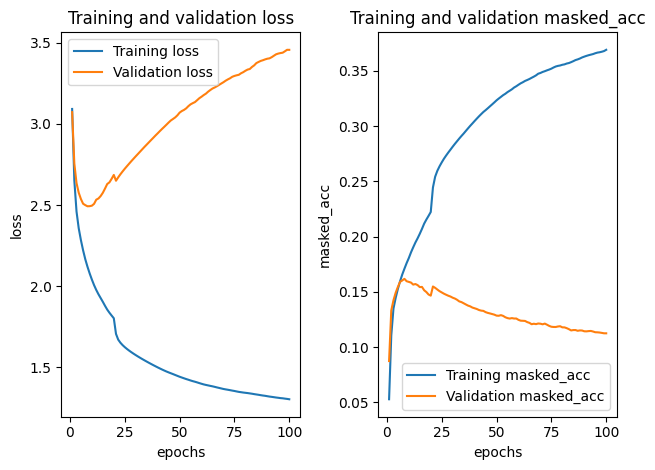

2.4927890300750732 The best number of epocs for the validation loss is 8
0.16173683106899261 The best number of epocs for the validation accuracy is 8


In [ ]:
# Subclassing API - 2 layers added training parameter on the call method
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 101s 195ms/step - loss: 3.4669 - masked_acc: 0.0413 - val_loss: 3.0971 - val_masked_acc: 0.0754
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.7492 - masked_acc: 0.0945 - val_loss: 2.7757 - val_masked_acc: 0.1299
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 189ms/step - loss: 2.5105 - masked_acc: 0.1300 - val_loss: 2.6620 - val_masked_acc: 0.1413
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 188ms/step - loss: 2.4021 - masked_acc: 0.1414 - val_loss: 2.6041 - val_masked_acc: 0.1467
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.3263 - masked_acc: 0.1487 - val_loss: 2.5723 - val_masked_acc: 0.1494
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 188ms/step - loss: 2.2698 - masked_acc: 0.1540 - val_loss: 2.5465 - val_masked_acc: 0.1517
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 85s 189ms/step - loss: 2.2190 - masked_acc: 0.1594 - val_loss: 2.5348 - val_masked_acc: 0.1530
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 18

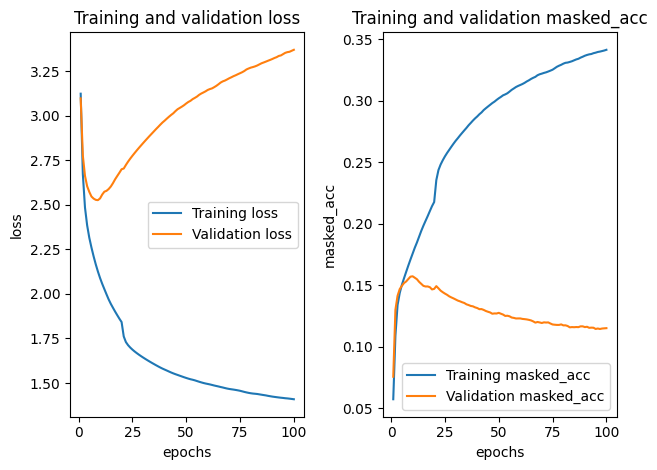

2.526020050048828 The best number of epocs for the validation loss is 9
0.1571703851222992 The best number of epocs for the validation accuracy is 10


In [ ]:
# Subclassing API - 1 layer added training parameter on the call method
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-09 00:27:56)

10% dataset

- **`NUM_ENCODERS = 1~2`**
- **`NUM_DECODERS = 1~2`**
- **Functional API, Subclassing API**
- `NORMALIZE_FIRST = True`
- `layer_norm_epsilon=1e-05`

Moreover, the following comparisons are executed.

- Functional API - 2 layers, norm_epsilon [1e-3, 1e-5]
- Functional API - 2 layers, norm_epsilon 1e-3
- Functional API - 2 layers, norm_epsilon 1e-9
- Functional API - 2 layers, norm_epsilon 1e-5(default)

#### Result

- The results between Subclassing API and Functional API do not differ from each other.
- `[1e-3, 1e-5]` is 3.6% better than `[1e-9, 1e-9]` at the 50th epoch.
- `[1e-3, 1e-3]` is 2.3% better than `[1e-3, 1e-5]` at the 50th epoch.

In [ ]:
# Functional API - 2 layers, norm_epsilon [1e-3, 1e-5]
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = [1e-3, 1e-5]
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, 256, 64)   │    152,152 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 128, 64)   │    968,192 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, 128, 64)   │    168,920 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,561,720 (13.59 MB)

 Trainable params: 3,561,720 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

get_config
Epoch 1/35


2024-07-09 00:27:56.604922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 293ms/step - loss: 3.4180 - masked_acc: 0.0396 - val_loss: 3.0702 - val_masked_acc: 0.0885
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 284ms/step - loss: 2.7138 - masked_acc: 0.1021 - val_loss: 2.7513 - val_masked_acc: 0.1328
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 280ms/step - loss: 2.4873 - masked_acc: 0.1317 - val_loss: 2.6370 - val_masked_acc: 0.1434
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 127s 281ms/step - loss: 2.3759 - masked_acc: 0.1429 - val_loss: 2.5765 - val_masked_acc: 0.1501
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 132s 291ms/step - loss: 2.2971 - masked_acc: 0.1510 - val_loss: 2.5341 - val_masked_acc: 0.1537
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 284ms/step - loss: 2.2296 - masked_acc: 0.1581 - val_loss: 2.5070 - val_masked_acc: 0.1577
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 127s 282ms/step - loss: 2.1722 - masked_acc: 0.1645 - val_loss: 2.4902 - val_masked_acc: 0.1602
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 280ms/step - l

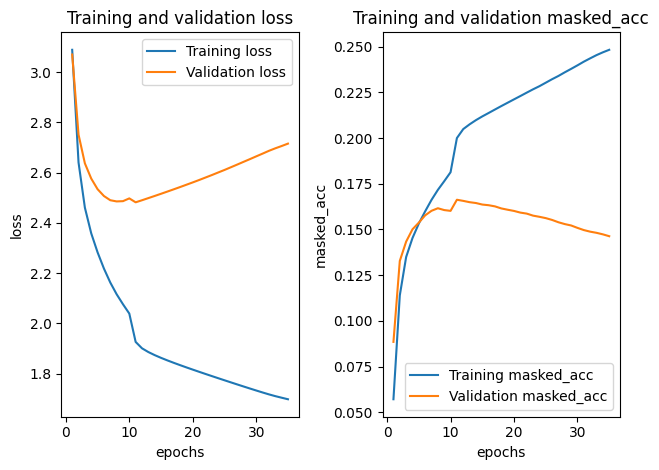

2.481921434402466 The best number of epocs for the validation loss is 11
0.1662621647119522 The best number of epocs for the validation accuracy is 11


In [19]:
# Functional API - 2 layers
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 278ms/step - loss: 3.4223 - masked_acc: 0.0457 - val_loss: 3.0687 - val_masked_acc: 0.0881
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 257ms/step - loss: 2.7159 - masked_acc: 0.1001 - val_loss: 2.7464 - val_masked_acc: 0.1334
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.4798 - masked_acc: 0.1329 - val_loss: 2.6346 - val_masked_acc: 0.1447
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.3724 - masked_acc: 0.1441 - val_loss: 2.5827 - val_masked_acc: 0.1495
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.2976 - masked_acc: 0.1511 - val_loss: 2.5427 - val_masked_acc: 0.1545
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.2328 - masked_acc: 0.1571 - val_loss: 2.5155 - val_masked_acc: 0.1571
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - loss: 2.1758 - masked_acc: 0.1635 - val_loss: 2.5002 - val_masked_acc: 0.1606
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 115s 256

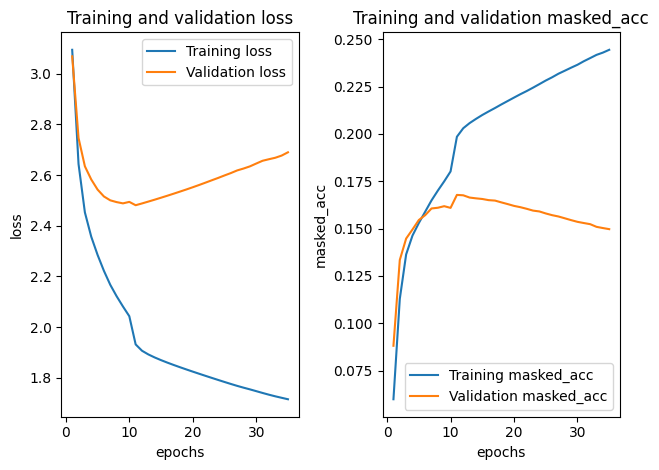

2.480922222137451 The best number of epocs for the validation loss is 11
0.1677982211112976 The best number of epocs for the validation accuracy is 11


In [20]:
# Subclassing API - 2 layers
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 128, 64)   │    968,192 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,240,648 (12.36 MB)

 Trainable params: 3,240,648 (12.36 MB)

 Non-trainable params: 0 (0.00 B)

get_config
Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 203ms/step - loss: 3.4669 - masked_acc: 0.0380 - val_loss: 3.0904 - val_masked_acc: 0.0847
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step - loss: 2.7395 - masked_acc: 0.0972 - val_loss: 2.7903 - val_masked_acc: 0.1291
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.5209 - masked_acc: 0.1291 - val_loss: 2.6737 - val_masked_acc: 0.1409
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step - loss: 2.4147 - masked_acc: 0.1401 - val_loss: 2.6112 - val_masked_acc: 0.1468
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 88s 195ms/step - loss: 2.3373 - masked_acc: 0.1475 - val_loss: 2.5708 - val_masked_acc: 0.1514
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - loss: 2.2777 - masked_acc: 0.1541 - val_loss: 2.5465 - val_masked_acc: 0.1552
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 90s 199ms/step - loss: 2.2256 - masked_acc: 0.1601 - val_loss: 2.5332 - val_masked_acc: 0.1547
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 89s

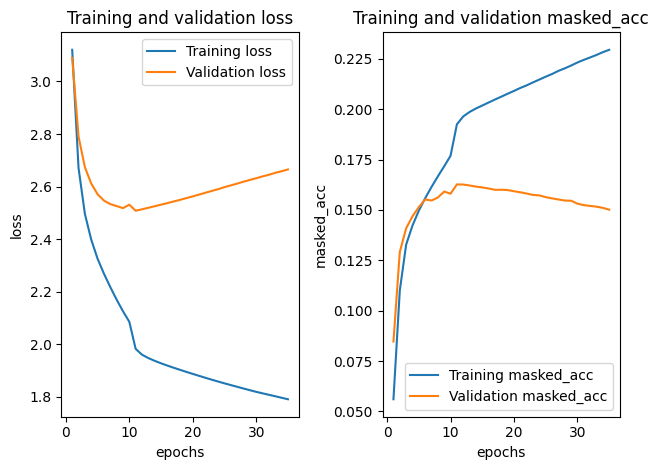

2.507861375808716 The best number of epocs for the validation loss is 11
0.1626758724451065 The best number of epocs for the validation accuracy is 11


In [21]:
# Functional API - 1 layer
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Epoch 1/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 106s 197ms/step - loss: 3.4607 - masked_acc: 0.0439 - val_loss: 3.0809 - val_masked_acc: 0.0855
Epoch 2/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 186ms/step - loss: 2.7520 - masked_acc: 0.0957 - val_loss: 2.8023 - val_masked_acc: 0.1283
Epoch 3/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.5290 - masked_acc: 0.1291 - val_loss: 2.6655 - val_masked_acc: 0.1425
Epoch 4/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - loss: 2.4072 - masked_acc: 0.1407 - val_loss: 2.6097 - val_masked_acc: 0.1474
Epoch 5/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.3349 - masked_acc: 0.1475 - val_loss: 2.5765 - val_masked_acc: 0.1523
Epoch 6/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - loss: 2.2819 - masked_acc: 0.1529 - val_loss: 2.5601 - val_masked_acc: 0.1541
Epoch 7/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - loss: 2.2358 - masked_acc: 0.1576 - val_loss: 2.5504 - val_masked_acc: 0.1555
Epoch 8/35
449/449 ━━━━━━━━━━━━━━━━━━━━ 84s 186ms/step

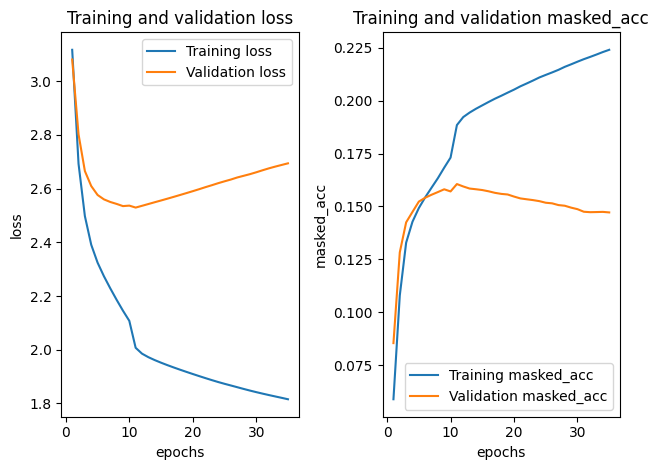

2.529484510421753 The best number of epocs for the validation loss is 11
0.16059942543506622 The best number of epocs for the validation accuracy is 11


In [22]:
# Subclassing API - 1 layer
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 10,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 128, 64)   │    968,192 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 256, 64)   │    152,152 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 128, 64)   │    168,920 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,561,720 (13.59 MB)

 Trainable params: 3,561,720 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

get_config
Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 192s 321ms/step - loss: 3.4190 - masked_acc: 0.0295 - val_loss: 3.0708 - val_masked_acc: 0.0871
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step - loss: 2.7191 - masked_acc: 0.1009 - val_loss: 2.7648 - val_masked_acc: 0.1309
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 294ms/step - loss: 2.4977 - masked_acc: 0.1307 - val_loss: 2.6452 - val_masked_acc: 0.1421
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 141s 312ms/step - loss: 2.3863 - masked_acc: 0.1409 - val_loss: 2.5841 - val_masked_acc: 0.1497
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 131s 292ms/step - loss: 2.3084 - masked_acc: 0.1495 - val_loss: 2.5378 - val_masked_acc: 0.1555
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 131s 291ms/step - loss: 2.2374 - masked_acc: 0.1571 - val_loss: 2.5038 - val_masked_acc: 0.1583
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 128s 285ms/step - loss: 2.1754 - masked_acc: 0.1641 - val_loss: 2.4858 - val_masked_acc: 0.1613
Epoch 8/100
449/449 ━━━━━━━━━━

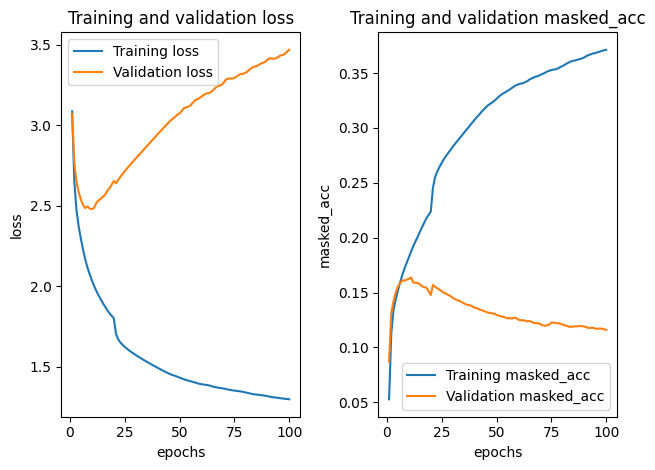

2.4794647693634033 The best number of epocs for the validation loss is 10
0.16379976272583008 The best number of epocs for the validation accuracy is 11


In [24]:
# Functional API - 2 layers, norm_epsilon 1e-3
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-3
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

In [ ]:
# Functional API - 2 layers, norm_epsilon 1e-9
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-9
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

In [ ]:
# Functional API - 2 layers, norm_epsilon 1e-5(default)
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 20,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

### Note (Experiment Date: 2024-07-07 23:40:00)

- `NORMALIZE_FIRST = True`
- `NUM_ENCODERS = 2`
- `NUM_DECODERS = 2`
- `layer_norm_epsilon=1e-06`

#### Result

- LAYER_NORM_EPSILON got 1/10 smaller, but almost nothing changed.

[<TransformerEncoder name=transformer_encoder_4, built=False>,
 <TransformerEncoder name=transformer_encoder_5, built=False>]
[<TransformerDecoder name=transformer_decoder_4, built=False>,
 <TransformerDecoder name=transformer_decoder_5, built=False>]
Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 330ms/step - loss: 3.3900 - masked_acc: 0.0439 - val_loss: 3.0563 - val_masked_acc: 0.0952
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 307ms/step - loss: 2.7058 - masked_acc: 0.1032 - val_loss: 2.7461 - val_masked_acc: 0.1336
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 314ms/step - loss: 2.4802 - masked_acc: 0.1329 - val_loss: 2.6345 - val_masked_acc: 0.1430
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 323ms/step - loss: 2.3706 - masked_acc: 0.1426 - val_loss: 2.5792 - val_masked_acc: 0.1488
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 2788s 6s/step - loss: 2.2915 - masked_acc: 0.1516 - val_loss: 2.5315 - val_masked_acc: 0.1550
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - loss: 2.2218

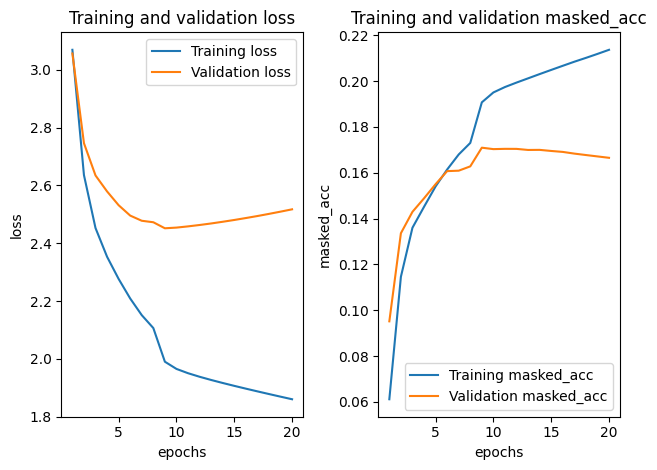

2.451754570007324 The best number of epocs for the validation loss is 9
0.17096149921417236 The best number of epocs for the validation accuracy is 9


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
LAYER_NORM_EPSILON = 1e-6
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 8,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

[<TransformerEncoder name=transformer_encoder_2, built=False>,
 <TransformerEncoder name=transformer_encoder_3, built=False>]
[<TransformerDecoder name=transformer_decoder_2, built=False>,
 <TransformerDecoder name=transformer_decoder_3, built=False>]
Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 167s 317ms/step - loss: 3.3891 - masked_acc: 0.0338 - val_loss: 3.0401 - val_masked_acc: 0.0956
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 134s 298ms/step - loss: 2.7034 - masked_acc: 0.1024 - val_loss: 2.7472 - val_masked_acc: 0.1334
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step - loss: 2.4812 - masked_acc: 0.1316 - val_loss: 2.6267 - val_masked_acc: 0.1439
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 134s 298ms/step - loss: 2.3654 - masked_acc: 0.1433 - val_loss: 2.5763 - val_masked_acc: 0.1510
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step - loss: 2.2940 - masked_acc: 0.1513 - val_loss: 2.5394 - val_masked_acc: 0.1547
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 297ms/step - loss: 2.23

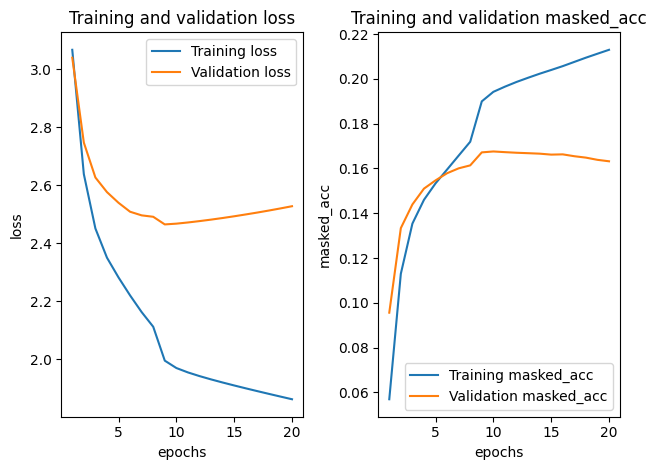

2.464806318283081 The best number of epocs for the validation loss is 9
0.1675938069820404 The best number of epocs for the validation accuracy is 10


In [20]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 128 #  1437 is the longest summarized text in dataset
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 2048
NORMALIZE_FIRST = True
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

learning_rate = get_exponential_decay_learning_rate(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
)
steps_per_epoch = 449
learning_rate_schedule = ExponentialWarmupSchedule(
    lr=0.001,
    decay_start=steps_per_epoch * 8,
    decay_ratio=0.1
)
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate_schedule,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=False,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[],
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

In [19]:
SENTENCES = [
    """By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to be interesting' Trio: Westwood, his son and Poulter were snapped in this selfie at Royal Liverpool during practice . The team: Westwood uploaded this photograph to Instagram after his son convinced him to join . Giving in: Westwood said his son convinced him to join the social networking website . The Open starts on Thursday, and sees Poulter tee off at 9.37am with Westwood at 2.38pm. The latter, though, may be under added pressure after Europe's Ryder Cup captain Paul McGinley urged the 41-year-old to up his game in Liverpool. 'We all know Lee has the pedigree,' said McGinley. 'If you look back at the Ryder Cup since 1997, he has been the one constant pillar of all our success during that time. 'I'm a huge fan, and I'm certainly not looking to rip up the template. But I have to justify every decision I make, so he has to show me some form.' Hit and miss: Europe's Ryder Cup captain Paul McGinley says Westwood must 'show me some form' 6.25am: David Howell (ENG), David Duval (USA), Robert Krlsson (SWE) 6.36am: Dawie van der Walt (RSA), Cameron Tringale (USA), Masanori Kobayashi (JPN) 6.47am: Chris Wood (ENG), Matt Jones (AUS), Bernd Wiesberger (AUT) 6.58am: Erik Compton (USA), Kim Hyung-sung (KOR), Marc Leishman (AUS) 7.09am: Koumei Oda (JPN), Ben Martin (USA), Anirban Lahiri (IND) 7.20am: Kiradech Aphibarnrat (THA), Brooks Koepka (USA), Edoardo Molinari (ITA) 7.31am: Branden Grace (RSA), Freddie Jacobson (SWE), Ashley Chesters (ENG) 7.42am: Justin Leonard (USA), Ben Curtis (USA), Paul Lawrie (SCO) 7.53am: Francesco Molinari (ITA), Ryan Moore (USA), Thorbjorn Olesen (DEN) 8.04am: Matteo Manassero (ITA), Bradley Neil (SCO), Mikko Ilonen (FIN) 8.15am: Thomas Bjorn (DEN), Patrick Reed (USA), Stewart Cink (USA) 8.26am: Ben Watson (USA), Jim Furyk (USA), Darren Clarke (NIR) 8.37am: Luke Donald (ENG), Rickie Fowler (USA), Sergio Garcia (ESP) 8.53am: Harris English (USA), Paul Casey (ENG), Matt Every (USA) 9.04am: Tiger Woods (USA), Angel Cabera (ARG), Henrik Stenson (SWE) 9.15am: Charl Schwartzel (RSA), Padraig Harrington (IRL), KJ Choi (KOR) 9.26am: Rory McIlroy (NIR), Hideki Matsuyama (JPN), Jordan Spieth (USA) 9.37am: Ian Poulter (ENG), Dustin Johnson (USA), Jimmy Walker (USA) 9.48am: Graeme McDowell (NIR), Matt Kuchar (USA), Louis Oosthuizen (RSA) 9.59am: Stephen Gallacher (SCO), Hunter Mahan (USA), Victor Dubuisson (FRA) 10.10am: Sir Nick Faldo (ENG), Todd Hamilton (USA), Mark Calcavecchia (USA) 10.21am: Ryan Palmer (USA), Brett Rumford (AUS), Tomohiro Kondo (JPN) 10.32am: John Singleton (ENG), Peter UIhlein (USA), Marc Warren (SCO) 10.43am: Paul McKechnie (SCO), Kristoffer Broberg (SWE), Juvic Pagunsan (PHI) 10.54am: Rhein Gibon (AUS), Brian Harman (USA), Kim Hyung-tae (KOR), . 11.05am: Chris Hanson (ENG), Oscar Floren (SWE), Yoshinobu Tsukada (JPN) 11.26am: James McLeary (SCO), Matthew Southgate (ENG), Hiroshi Iwata (JPN) 11.37am: Roberto Castro (USA), Victor Riu (FRA), Tyrrell Hatton (ENG) 11.48am: Jang Dong-kyu (KOR), Nick Watney (USA), Shawn Stefani (USA) 11.59am: D A Points (USA), Ye Yang (KOR), Brendan Steele (USA) 12.10pm: Scott Stallings (USA), Pablo Larrazabal (ESP), Bryden Macpherson (AUS) 12.21pm: George Coetzee (RSA), Charley Hoffman (USA), Michael Hoey (NIR) 12.32pm: Kevin Streelman (USA), Brendon de Jonge (ZIM), Brendon Todd (USA) 12.43pm: Gary Woodland (USA), Sandy Lyle (SCO), Kevin Stadler (USA) 12.54pm: Brandt Snedeker (USA), Graham Delaet (CAN), Pan Cheng-tsung (TPE) 1.05pm: Boo Weekley (USA), Danny Willett (ENG), Wu Ashun (CHN) 1.16pm: JB Holmes (USA), Jonas Blixt (SWE), Chris Kirk (USA) 1.27pm: Miguel Angel Jiminez (ESP), Bill Haas (USA), Thongchai Jaidee (THA) 1.38pm: Martin Kaymer (GER), Jason Day (AUS), Zach Johnson (USA) 1.54pm: Webb Simpson (USA), Jamie Donaldson (WAL), Yusaku Miyazato (JPN) 2.05pm: Phil Mickelson (USA), Ernie Els (RSA), Bubba Watson (USA) 2.16pm: Gonzalo Fernandez-Castano (ESP), Russell Henley (USA), Billy Horschel (USA) 2.27pm: Adam Scott (AUS), Justin Rose (ENG), Jason Dufne (USA) 2.38pm: Ryo Ishikawa (JPN), Lee Westwood (ENG), Keegan Bradley (USA) 2.49pm: Kevin Na (USA), Joost Luiten (HOL), John Senden (AUS) 3.00pm: John Daly (USA), Tommy Fleetwood (ENG), Ross Fisher (ENG) 3.11pm: Mark Wiebe (USA), Rafael Cabrera-bello (ESP), Paul Dunne (IRL) 3.22pm: Oliver Fisher (ENG), Chesson Hadley (USA), Shane Lowry (IRL) 3.33pm: George McNeill (USA), Richard Sterne (RSA), Chris Stroud (USA) 3.44pm: Gregory Bourdy (FRA), Jin Jeong (KOR), Matthew Baldwin (ENG) 3.55pm: Justin Walters (RSA), Rhys Enoch (WAL), Billy Hurley III (USA) 4.06pm: Christoper Rodgers (ENG), Scott Jamieson (SCO), An Byeong-hun (KOR)""",
    """The Catholic Church has taken a 'step in the right direction' by holding talks on how to provide better spiritual care to homosexual members, gay rights activists said today. Following Pope Francis' famous 'Who am I to judge?' comment on homosexuality last year,\xc2\xa0bishops have repeatedly spoken of the need to change the church's language towards gays from words of moral condemnation and judgment, to words of welcome and respect. Now\xc2\xa0for the first time a Vatican meeting is discussing gay and lesbian issues within the Church - a move described as 'a crack in the ice that we have been waiting for, for a very long time' by the Catholic gay rights group\xc2\xa0New Ways Ministry. Scroll down for video . Discussions: Pope Francis talks to prelates as he arrives for a morning session of a two-week synod on family issues, at the Vatican this morning. Among the issues the synod will debate will be how to provide better spiritual care to homosexual members . New era: The decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis (pictured today) Despite their apparent softening on the issue, the Vatican's top canon lawyer was keen to make clear that the ongoing discussions will not focus on changing the Church's\xc2\xa0doctrine on homosexuality, nor will it lead to an endorsement of gay marriage or even gay unions. But the decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis. On the other hand the last pope, Benedict XVI, penned some of the modern Catholic Church's key documents opposing homosexuality\xc2\xa0when he was head the Vatican's orthodoxy office in the 1980s. 'I think what we're seeing is a crack in the ice that we have been waiting for, for a very long time,' said Francis DeBernardo, executive director of New Ways Ministry. 'It's a sign of a first step.' Church teaching holds that gay acts are 'intrinsically disordered,' sinful and a 'serious depravity,' and that homosexual inclination is 'objectively disordered.'\xc2\xa0At the same time, it says homosexuals themselves must be treated with respect and compassion and not suffer discrimination. 'I know scores of people who have left the Catholic Church because of those words,' DeBernardo said. Progressive: The Vatican synod is discussing gay and lesbian issues within the Church for the first time. The move has been described as 'a crack in the ice' by the Catholic gay rights group New Ways Ministry . Emeritus Pope Benedict XVI penned some of the Vatican's key documents on gays when he headed the Vatican's orthodoxy office; a 1986 letter of his to bishops on providing pastoral care to gays insisted that any church program must clearly state 'that homosexual activity is immoral.' His 2003 document opposing same-sex unions made clear that 'there are absolutely no grounds for considering homosexual unions to be in any way similar or even remotely analogous to God's plan for marriage and family.' The Vatican's top canon lawyer, Cardinal Francesco Coccopalmerio, yesterday said that the Catholic Church would 'never' accept gay marriage or even bless a gay union. Despite that unbending position, there's no doubting that a shift in tone has occurred. Michael Brinkschroeder, co-president of the European Forum of LGBT Christian Groups, said \xc2\xa0it was clear that the synod won't change doctrine, but that the 'Francis effect' appeared to be trickling down to local bishops. Many had 'lost their fear' and are freer now to engage in dialogue with gays in a way they couldn't under the last two popes, he said. 'With Benedict vanished from the scene, Francis has given signals for bishops to start pastoral work and dialogue,' he said. Welcome: Vatican Swiss Guards  salute Pope Francis as he arrives for the synod earlier in the week . Pope\xc2\xa0Francis famously said 'Who am I to judge?' when asked in 2013 about rumors that a top priestly adviser had a gay lover. DeBernardo, of New Ways Ministry, said the next step is for gays to be at the table offering their testimony to bishops. No openly gay Catholics have addressed the closed-door synod, but two Catholic heterosexual couples have spoken about experiences of devout Catholics welcoming gays or trying to provide pastoral care for them. He said he was 'euphoric' that some bishops had said language such as 'intrinsically disordered' was wholly ineffective in bringing people closer to the church. Not so fast, say conservative Catholics. Hard-line Cardinal Raymond Burke, who heads the Vatican's high court, insisted that gay sex was and will remain 'intrinsically disordered' and children must be protected from thinking otherwise. He was responding to testimony from an Australian Catholic couple who told the synod about friends who welcomed their gay son and his partner to a Christmas party. 'That particular form of relationship should not be imposed upon family members, and especially upon impressionable children,' Burke told the conservative LifeSiteNews. 'And I urge parents or grandparents - whoever it may be - to be very, very prudent in this matter and not to scandalize their children or grandchildren.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend ."""
]
predict_model(
    model=model,
    examples=SENTENCES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
print("")

ORIGINAL SENTENCE:  By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to 